# Comment analysis

In [47]:
! pip install numpy==1.24.4 scipy==1.10.1
! pip install pandas matplotlib seaborn scikit-learn transformers statsmodels
! pip install pandas matplotlib seaborn scikit-learn transformers


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [48]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
import re
import os
from datetime import datetime
from scipy.stats import f
import statsmodels.api as sm
import statsmodels.stats.proportion as smp
from statsmodels.api import OLS
from statsmodels.api import add_constant
import nltk

In [49]:
model_path = "rubert-finetuned-v2"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [50]:
pipeline = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    truncation=True,  
    max_length=512            
)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/Applications/anaconda3/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [51]:
df_comments = pd.read_csv("data/data_clean/comments_labeled_manual.csv")

# Making sure there's no missing text
df_comments = df_comments[df_comments["text_transformed"].notna() & (df_comments["text_transformed"].str.strip() != "")]

In [52]:
texts = df_comments["text_transformed"].tolist()

from tqdm import tqdm
results = []
for i in tqdm(range(0, len(texts), 32)):
    batch = texts[i:i+32]
    results.extend(pipeline(batch))

df_comments["model_sentiment"] = [max(r, key=lambda x: x["score"])["label"] for r in results]

100%|██████████| 985/985 [00:59<00:00, 16.53it/s]


In [53]:
df_comments = pd.read_csv("data/data_clean/comments_with_adjusted_sentiment.csv")

In [54]:
df_comments["period"].value_counts(), df_comments["model_sentiment"].value_counts()

(post    28838
 pre      2682
 Name: period, dtype: int64,
 neutral     14286
 negative     8918
 positive     8316
 Name: model_sentiment, dtype: int64)

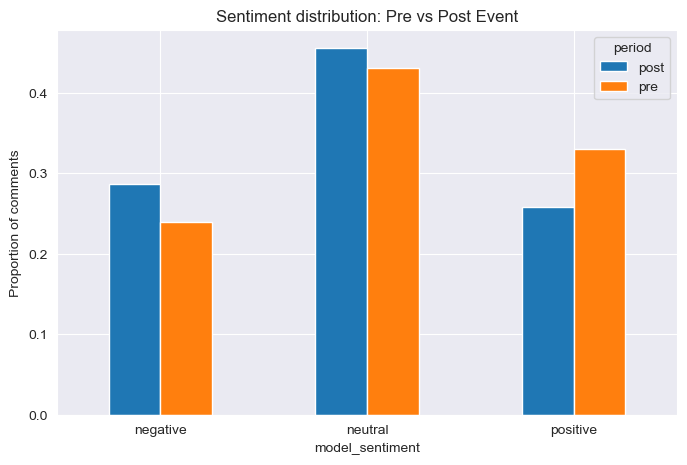

In [55]:
# Computing counts and normalize
sent_dist = df_comments.groupby(["period", "model_sentiment"]).size().unstack().fillna(0)
sent_dist_normalized = sent_dist.div(sent_dist.sum(axis=1), axis=0)

# Plotting
sent_dist_normalized.T.plot(kind="bar", figsize=(8,5), title="Sentiment distribution: Pre vs Post Event")
plt.ylabel("Proportion of comments")
plt.xticks(rotation=0)
plt.savefig("figures/seentiment_distr.png", dpi=600, bbox_inches="tight")
plt.show()

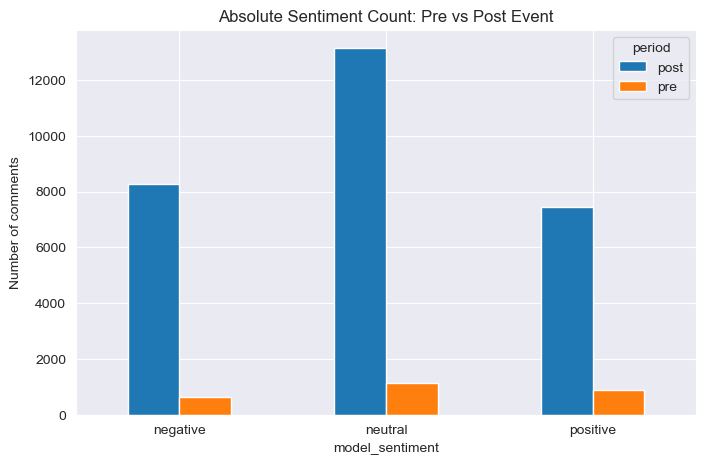

In [56]:
sent_dist.T.plot(kind="bar", figsize=(8,5), title="Absolute Sentiment Count: Pre vs Post Event")
plt.ylabel("Number of comments")
plt.xticks(rotation=0)
plt.savefig("figures/seentiment_count.png", dpi=600, bbox_inches="tight")
plt.show()

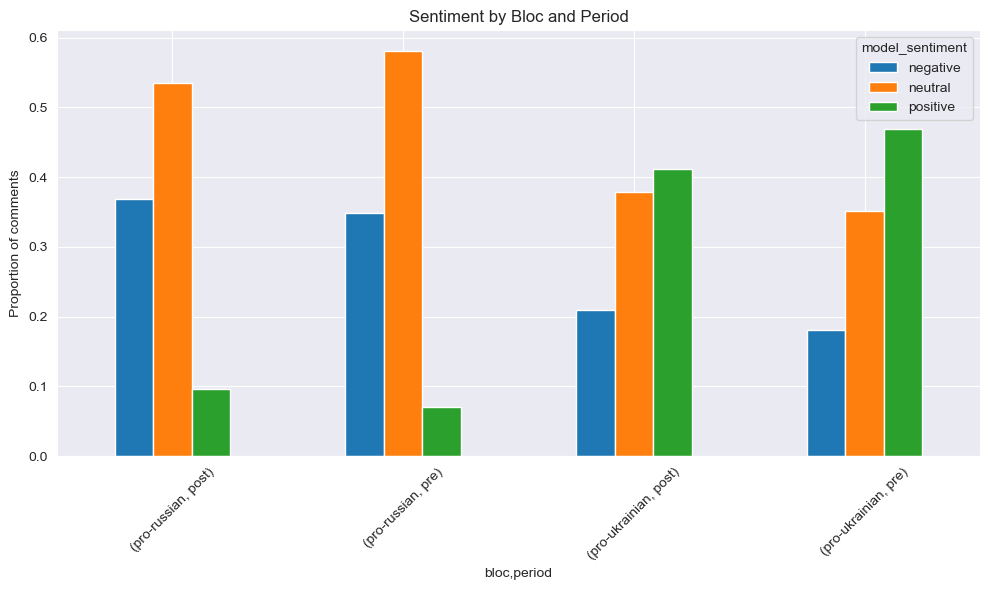

In [57]:
bloc_dist = df_comments.groupby(["bloc", "period", "model_sentiment"]).size().unstack().fillna(0)
bloc_normalized = bloc_dist.div(bloc_dist.sum(axis=1), axis=0)

# Plotting grouped bar chart
bloc_normalized.plot(kind="bar", figsize=(10,6), title="Sentiment by Bloc and Period")
plt.ylabel("Proportion of comments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/sentiment_by_bloc.png", dpi=600, bbox_inches="tight")
plt.show()

In [58]:
event_date = pd.to_datetime("2025-02-28")
df_comments["comment_date"] = pd.to_datetime(df_comments["comment_date"])
df_comments["days_relative"] = (df_comments["comment_date"] - event_date).dt.days

In [59]:
event_date = pd.to_datetime("2025-02-28")

# Checking on range of comment dates
print("min/max comment_date:", df_comments["comment_date"].min(), df_comments["comment_date"].max())

# Recomputing days_relative cleanly (drop tz and floor to day to avoid off-by-ones)
cd = pd.to_datetime(df_comments["comment_date"], errors="coerce")
cd = cd.dt.tz_localize(None, nonexistent="shift_forward", ambiguous="NaT") if hasattr(cd, "dt") else cd
df_comments["days_relative_check"] = (cd.dt.floor("D") - event_date).dt.days

print("min/max days_relative:", df_comments["days_relative_check"].min(), df_comments["days_relative_check"].max())

# Showing offending rows outside ±14
off = df_comments.loc[(df_comments["days_relative_check"] < -14) | (df_comments["days_relative_check"] > 14),
                      ["comment_date","days_relative_check","bloc","text_transformed"]]
print("Rows outside window:", len(off))
off.head(10)

min/max comment_date: 2025-02-19 05:13:33 2025-05-19 07:25:10
min/max days_relative: -9 80
Rows outside window: 16


,comment_date,days_relative_check,bloc,text_transformed
1435,2025-03-19 07:08:53,19,pro-ukrainian,а чого ти коментарі видаляєш?
2111,2025-03-18 10:49:22,18,pro-ukrainian,"розпад срср та війни, що відбулись на його тер..."
18442,2025-03-27 01:46:03,27,pro-russian,":face_with_tears_of_joy "" битва нанайских мал..."
22482,2025-05-19 07:25:10,80,pro-russian,уже съели... ночной дожор был.. :beaming_face_...
22483,2025-05-19 07:24:34,80,pro-russian,этот окорок ещё в марте был оттцкшен:beaming_f...
22484,2025-05-19 07:23:47,80,pro-russian,унесите окорок :pig_face :index_pointing_up_se...
22830,2025-03-23 18:40:56,23,pro-russian,"старлинк отключите, разведданные не передавайт..."
22880,2025-04-23 05:48:11,54,pro-russian,не смешите мои тапки. будут поставлять оружие ...
22881,2025-03-24 20:54:23,24,pro-russian,а если все же это всемирный спектакль?..
23198,2025-03-23 22:25:01,23,pro-russian,"так это пол месяца назад было,че опять то пока..."


In [60]:
# Masking for rows outside ±14-day window
mask_outliers = (df_comments["days_relative"] < -14) | (df_comments["days_relative"] > 14)
outliers = df_comments.loc[mask_outliers, ["comment_date","days_relative","bloc","text_transformed"]]

# Sorting by date for readability
outliers = outliers.sort_values("comment_date")

# Showing how many and peek
print("Total outliers:", len(outliers))
display(outliers.head(20))

Total outliers: 16


,comment_date,days_relative,bloc,text_transformed
23959,2025-03-16 16:50:27,16,pro-russian,только и могут свои налеты дронов устраивать о...
23958,2025-03-16 17:06:26,16,pro-russian,"окраина и не так может удивить, утилизация всу..."
2111,2025-03-18 10:49:22,18,pro-ukrainian,"розпад срср та війни, що відбулись на його тер..."
1435,2025-03-19 07:08:53,19,pro-ukrainian,а чого ти коментарі видаляєш?
22830,2025-03-23 18:40:56,23,pro-russian,"старлинк отключите, разведданные не передавайт..."
23198,2025-03-23 22:25:01,23,pro-russian,"так это пол месяца назад было,че опять то пока..."
22881,2025-03-24 20:54:23,24,pro-russian,а если все же это всемирный спектакль?..
18442,2025-03-27 01:46:03,27,pro-russian,":face_with_tears_of_joy "" битва нанайских мал..."
29831,2025-04-05 12:38:20,36,pro-russian,так это повтор
31451,2025-04-05 17:45:29,36,pro-russian,"не дай бог, присоеденить этот свинарник"


In [61]:
df_comments = df_comments[
    (df_comments["days_relative"] >= -14) & 
    (df_comments["days_relative"] <= 14)
].copy()

Here I have notices that the variable which I have calculated earlier is wrong and i will fix it now

In [62]:
df_comments["comment_date"] = pd.to_datetime(df_comments["comment_date"])
df_comments["date"] = pd.to_datetime(df_comments["date"])

In [63]:
df_comments["post_age_at_comment"] = (df_comments["comment_date"] - df_comments["date"]).dt.total_seconds() / 86400

In [64]:
df_comments[["date", "comment_date", "post_age_at_comment"]].sample(5)

,date,comment_date,post_age_at_comment
23242,2025-02-28 17:51:34,2025-02-28 19:51:35,0.083345
7015,2025-02-28 18:44:19,2025-02-28 18:46:07,0.001250
12354,2025-03-02 16:13:12,2025-03-02 16:47:19,0.023692
10917,2025-02-28 17:26:37,2025-02-28 17:36:24,0.006794
15242,2025-02-28 18:25:37,2025-02-28 18:27:11,0.001088


In [65]:
f_comments = df_comments[df_comments["post_age_at_comment"] >= 0]
df_comments = df_comments.dropna(subset=["post_age_at_comment"])

In [66]:
df_comments.drop(columns=["post_age_at_comment"], inplace=True)

In [67]:
filtered = df_comments[df_comments["days_relative"].between(-14, 14)]
grouped = filtered.groupby(["days_relative", "model_sentiment"]).size().unstack(fill_value=0)
filtered["days_relative"] = filtered["days_relative"].astype(int)

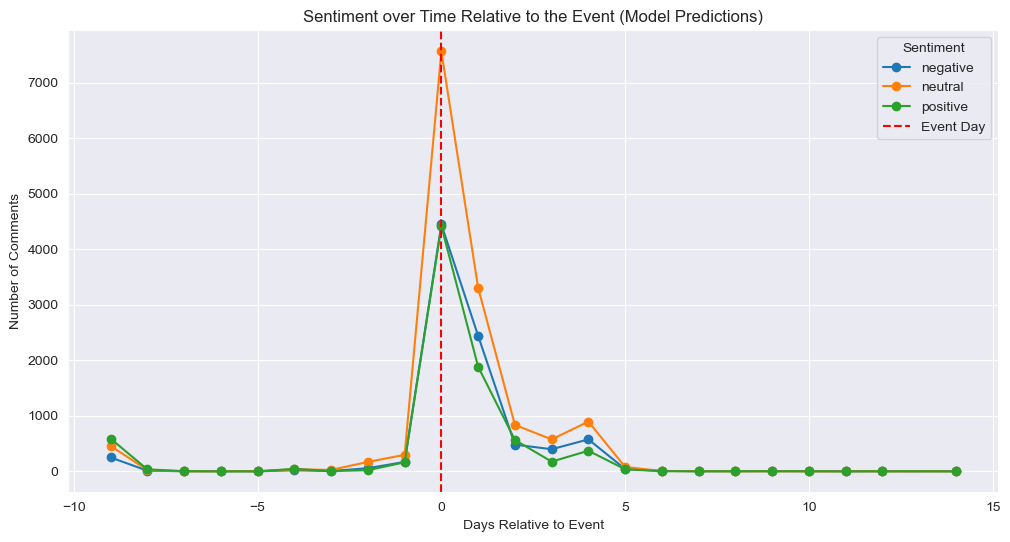

In [68]:
grouped.plot(figsize=(12, 6), linestyle='-', marker='o')
plt.axvline(x=0, color="red", linestyle='--', label="Event Day")
plt.xlabel("Days Relative to Event")
plt.ylabel("Number of Comments")
plt.title("Sentiment over Time Relative to the Event (Model Predictions)")
plt.legend(title="Sentiment")
plt.grid(True)
plt.show()

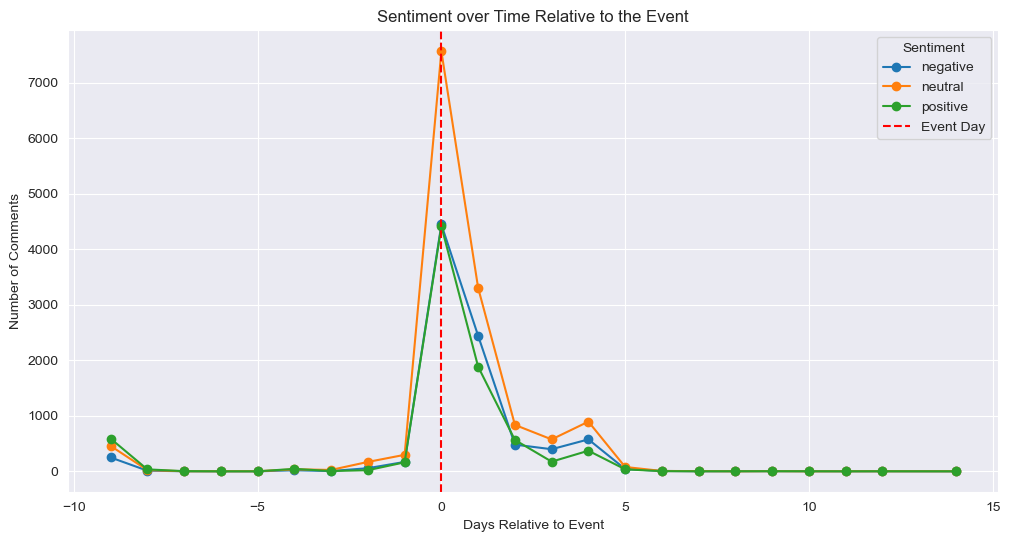

In [69]:
df_comments["days_relative_int"] = df_comments["days_relative"].astype(int)
grouped = df_comments.groupby(["days_relative_int", "model_sentiment"]).size().unstack(fill_value=0)
grouped.plot(
    figsize=(12, 6),
    linestyle='-',
    marker='o'
)
# Plot
plt.axvline(x=0, color='red', linestyle='--', label="Event Day")
plt.xlabel("Days Relative to Event")
plt.ylabel("Number of Comments")
plt.title("Sentiment over Time Relative to the Event")
plt.legend(title="Sentiment")
plt.grid(True)
plt.show()

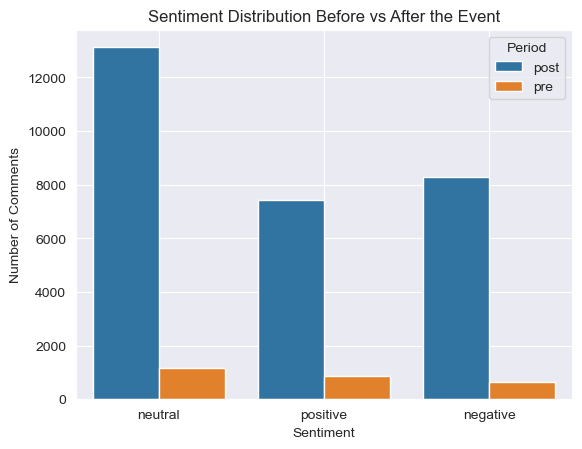

In [70]:
sns.countplot(data=df_comments, x="model_sentiment", hue="period")
plt.title("Sentiment Distribution Before vs After the Event")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.legend(title="Period")
plt.grid(True)
plt.show()

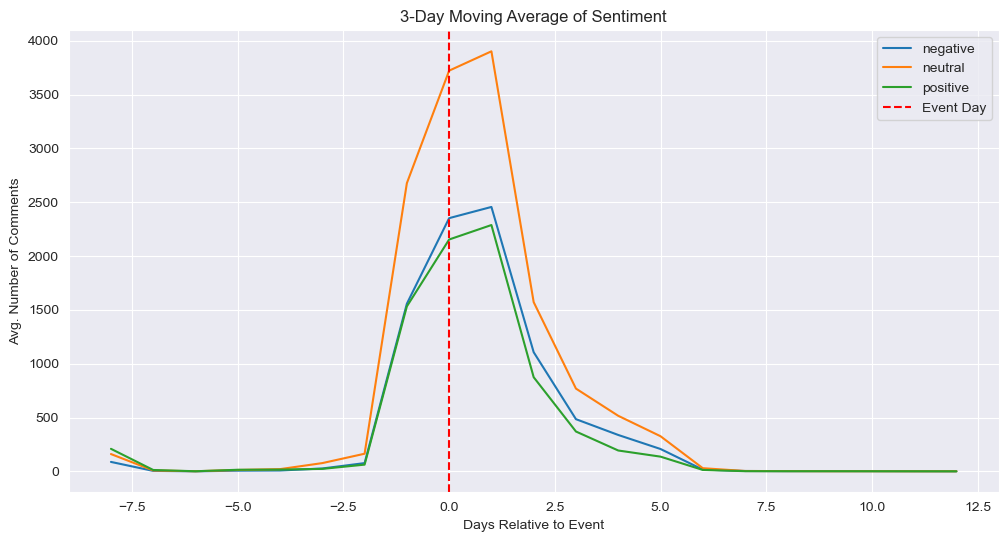

In [71]:
rolling = df_comments.copy()
rolling["days_relative_int"] = rolling["days_relative"].astype(int)

rolling_counts = (
    rolling.groupby(["days_relative_int", "model_sentiment"]).size().unstack(fill_value=0)
    .rolling(window=3, center=True).mean()
)

rolling_counts.plot(figsize=(12,6), title="3-Day Moving Average of Sentiment")
plt.axvline(x=0, color="red", linestyle='--', label="Event Day")
plt.xlabel("Days Relative to Event")
plt.ylabel("Avg. Number of Comments")
plt.grid(True)
plt.legend()
plt.show()

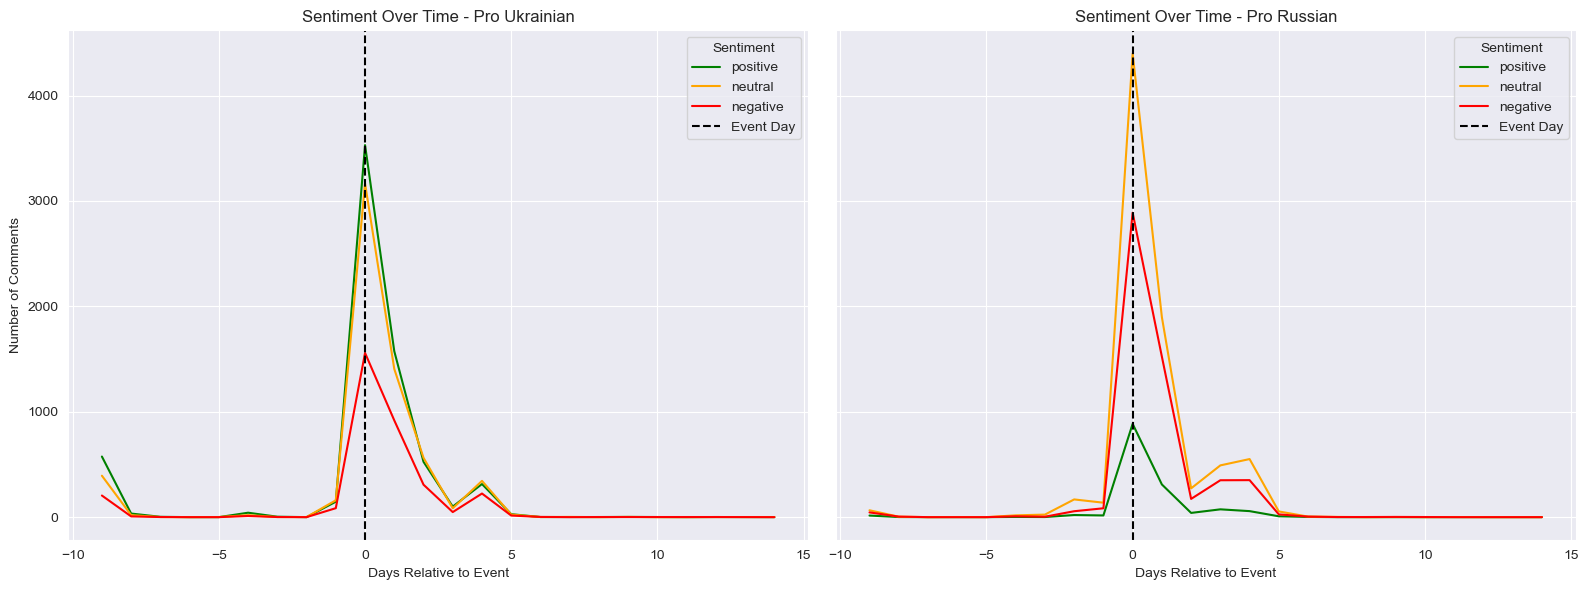

In [72]:
# Ensuring integer days for grouping
df_comments["days_relative_int"] = df_comments["days_relative"].astype(int)

# Groupping: count comments per day, sentiment, and bloc
grouped = df_comments.groupby(["bloc", "days_relative_int", "model_sentiment"]).size().reset_index(name="count")

# Pivoting so we can plot easily
pivoted = grouped.pivot_table(index="days_relative_int", columns=["bloc", "model_sentiment"], values="count", fill_value=0)

# Plotting: one plot for each bloc
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=True)

blocs = ["pro-ukrainian", "pro-russian"]
colors = {"positive": "green", "neutral": "orange", "negative": "red"}

for i, bloc in enumerate(blocs):
    ax = axes[i]
    for sentiment in ["positive", "neutral", "negative"]:
        if (bloc, sentiment) in pivoted.columns:
            ax.plot(pivoted.index, pivoted[bloc, sentiment], label=sentiment, color=colors[sentiment])
    ax.axvline(x=0, color="black", linestyle="--", label="Event Day")
    ax.set_title(f"Sentiment Over Time - {bloc.replace('-', ' ').title()}")
    ax.set_xlabel("Days Relative to Event")
    ax.grid(True)
    if i == 0:
        ax.set_ylabel("Number of Comments")
    ax.legend(title="Sentiment")

plt.tight_layout()
plt.savefig("figures/sentiment_over_time.png", dpi=600, bbox_inches="tight")
plt.show()

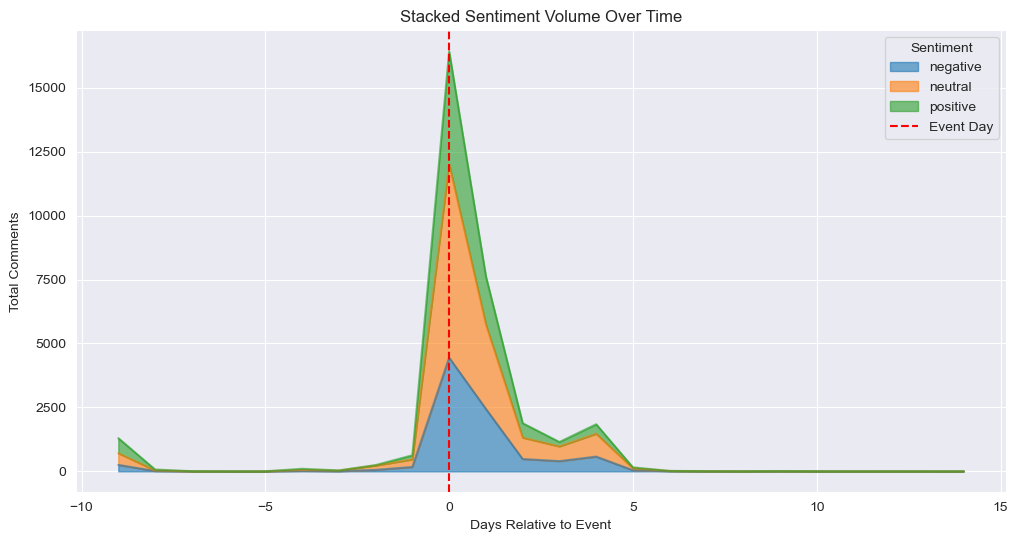

In [73]:
grouped = df_comments.groupby(["days_relative_int", "model_sentiment"]).size().unstack(fill_value=0)
grouped.plot.area(stacked=True, figsize=(12,6), alpha=0.6)
plt.axvline(x=0, color="red", linestyle='--', label="Event Day")
plt.xlabel("Days Relative to Event")
plt.ylabel("Total Comments")
plt.title("Stacked Sentiment Volume Over Time")
plt.grid(True)
plt.legend(title="Sentiment")
plt.show()

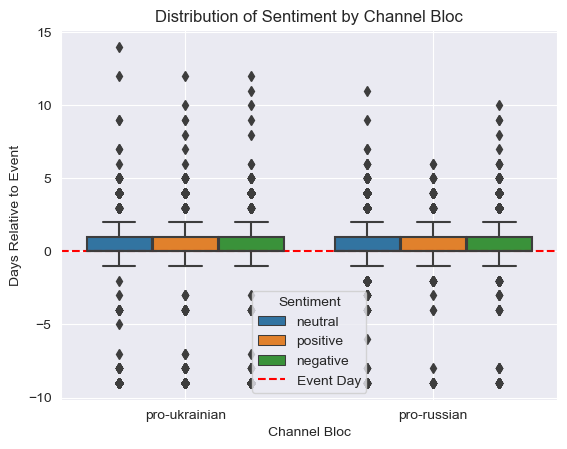

In [74]:
sns.boxplot(data=df_comments, x="bloc", y="days_relative", hue="model_sentiment")
plt.axhline(0, color="red", linestyle='--', label="Event Day")
plt.title("Distribution of Sentiment by Channel Bloc")
plt.ylabel("Days Relative to Event")
plt.xlabel("Channel Bloc")
plt.legend(title="Sentiment")
plt.grid(True)
plt.show()

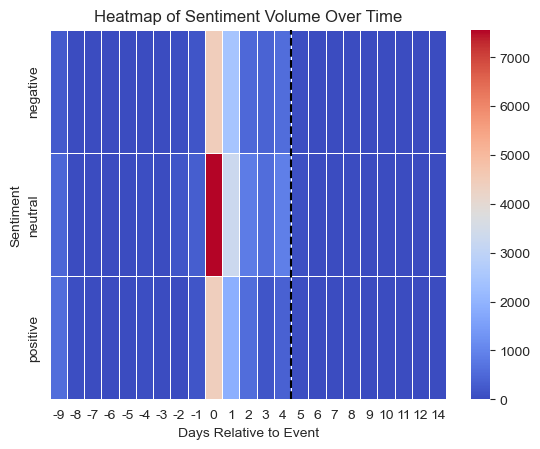

In [75]:
heatmap_data = df_comments.groupby(["days_relative_int", "model_sentiment"]).size().unstack(fill_value=0)
sns.heatmap(heatmap_data.T, cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap of Sentiment Volume Over Time")
plt.xlabel("Days Relative to Event")
plt.ylabel("Sentiment")
plt.axvline(x=14, color="black", linestyle="--")  # Mark event day if needed
plt.show()

In [76]:
sentiment_map = {"negative": -1, "neutral": 0, "positive": 1}
df_comments["sentiment_score"] = df_comments["model_sentiment"].map(sentiment_map)

In [77]:
# Filtering to ±14 days around the event using the relative counter we already have
df14 = df_comments[(df_comments["days_relative"] >= -14) & (df_comments["days_relative"] <= 14)]

In [78]:
# Aggregating mean polarity per bloc per relative day
g = (df14
     .groupby(["days_relative","bloc"])["sentiment_score"]
     .mean()
     .unstack("bloc"))

In [79]:
# Keeping only days, where BOTH blocs have data (avoid NaN gaps)
g = g[["pro-ukrainian","pro-russian"]].dropna(how="any")

In [80]:
# Sentiment Gap Index
g["gap"] = g["pro-ukrainian"] - g["pro-russian"]

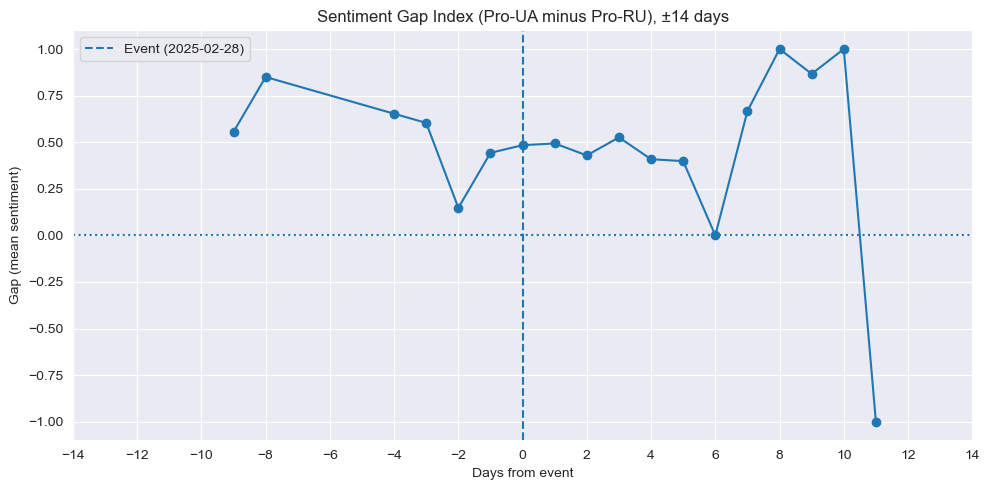

In [81]:
# Plot with event at 0
plt.figure(figsize=(10,5))
plt.plot(g.index, g["gap"], marker='o')
plt.axvline(0, linestyle='--', label="Event (2025-02-28)")
plt.axhline(0, linestyle=':')
plt.title("Sentiment Gap Index (Pro-UA minus Pro-RU), ±14 days")
plt.xlabel("Days from event")
plt.ylabel("Gap (mean sentiment)")
plt.xticks(range(-14, 15, 2))
plt.legend()
plt.tight_layout()
plt.savefig("figures/sentiment_gap_index.png", dpi=600, bbox_inches="tight")
plt.show()

### For the Chaw Test

In [82]:
# Mapping sentiment to numeric scores
sentiment_map = {"negative": -1, "neutral": 0, "positive": 1}
df_comments["sentiment_score"] = df_comments["model_sentiment"].map(sentiment_map)

In [83]:
# Dropping NA values (just in case)
df_comments = df_comments.dropna(subset=["sentiment_score", "days_relative"])

In [84]:
# Splitting data
pre_event = df_comments[df_comments["days_relative"] < 0]
post_event = df_comments[df_comments["days_relative"] >= 0]

In [85]:
# Fitting regression models
X_all = df_comments[["days_relative"]].values
y_all = df_comments["sentiment_score"].values
model_all = LinearRegression().fit(X_all, y_all)
rss_all = np.sum((y_all - model_all.predict(X_all)) ** 2)

# --- Pre-event ---
X_pre = pre_event[["days_relative"]].values
y_pre = pre_event["sentiment_score"].values
model_pre = LinearRegression().fit(X_pre, y_pre)
rss_pre = np.sum((y_pre - model_pre.predict(X_pre)) ** 2)

# --- Post-event --- 
X_post = post_event[["days_relative"]].values
y_post = post_event["sentiment_score"].values
model_post = LinearRegression().fit(X_post, y_post)
rss_post = np.sum((y_post - model_post.predict(X_post)) ** 2)

In [86]:
# Chow test
k = 2  # intercept + slope
n_pre = len(pre_event)
n_post = len(post_event)

numerator = (rss_all - (rss_pre + rss_post)) / k
denominator = (rss_pre + rss_post) / (n_pre + n_post - 2 * k)

chow_F = numerator / denominator
p_value = 1 - f.cdf(chow_F, dfn=k, dfd=(n_pre + n_post - 2 * k))

# --- Output ---
print(f"Chow F-statistic: {chow_F:.3f}")
print(f"p-value: {p_value:.5f}")

Chow F-statistic: 3.332
p-value: 0.03573


# Interpretation

1. F-statistic = 8.674
This value is the test statistic. It measures how different the two regressions (pre- and post-event) are from the combined regression (whole period). Higher = more difference.

2. p-value = 0.00017
This is very low (well below the common alpha level of 0.05).
It means: we can reject the null hypothesis that there's no difference between the two time periods.

There is statistically significant evidence that the relationship between sentiment and time shifted after the Trump–Zelensky event.
In simpler terms: the way sentiment evolved before the event is not the same as after.
This validates that the event likely marked a change in discourse tone in the Telegram comments.



In [87]:
def chow_test(df, x_col, y_col, breakpoint):
    df = df.sort_values(by=x_col)
    df_pre = df[df[x_col] < breakpoint]
    df_post = df[df[x_col] >= breakpoint]

    X_full = add_constant(df[x_col])
    X_pre = add_constant(df_pre[x_col])
    X_post = add_constant(df_post[x_col])

    y_full = df[y_col]
    y_pre = df_pre[y_col]
    y_post = df_post[y_col]

    model_full = OLS(y_full, X_full).fit()
    model_pre = OLS(y_pre, X_pre).fit()
    model_post = OLS(y_post, X_post).fit()

    RSS_pooled = sum((model_full.predict(X_full) - y_full) ** 2)
    RSS1 = sum((model_pre.predict(X_pre) - y_pre) ** 2)
    RSS2 = sum((model_post.predict(X_post) - y_post) ** 2)

    k = X_full.shape[1]  # number of parameters
    n1 = len(X_pre)
    n2 = len(X_post)

    chow_F = ((RSS_pooled - (RSS1 + RSS2)) / k) / ((RSS1 + RSS2) / (n1 + n2 - 2 * k))
    from scipy.stats import f
    p_value = 1 - f.cdf(chow_F, dfn=k, dfd=n1 + n2 - 2 * k)

    return chow_F, p_value

In [88]:
sentiment_map = {"negative": -1, "neutral": 0, "positive": 1}
df_comments["sentiment_numeric"] = df_comments["model_sentiment"].map(sentiment_map)

In [89]:
for bloc in ["pro-ukrainian", "pro-russian"]:
    df_bloc = df_comments[df_comments["bloc"] == bloc]
    df_bloc = df_bloc.dropna(subset=["days_relative", "sentiment_numeric"])
    
    print(f"Rows in df_bloc ({bloc}): {len(df_bloc)}")  # Moved here

    chow_F, p_value = chow_test(df_bloc, "days_relative", "sentiment_numeric", breakpoint=0)

    print(f"\nBloc: {bloc}")
    print(f"Chow F-statistic: {chow_F:.3f}")
    print(f"p-value: {p_value:.5f}")

Rows in df_bloc (pro-ukrainian): 16459

Bloc: pro-ukrainian
Chow F-statistic: 6.557
p-value: 0.00142
Rows in df_bloc (pro-russian): 15045

Bloc: pro-russian
Chow F-statistic: 2.007
p-value: 0.13440


# Interpretation:
### Pro-ukrainian:
This is statistically significant (p < 0.05).

We reject the null hypothesis that sentiment followed the same linear trend before and after the event.

There was a structural change in sentiment among pro-Ukrainian users around the Trump–Zelensky event.

The event likely had a meaningful impact on how pro-Ukrainian Telegram users were expressing themselves.

### Pro-russian:
This is not statistically significant (p > 0.05).

We fail to reject the null hypothesis — no evidence of a structural break.

Sentiment among pro-Russian users did not change significantly at the event time.

Either the event had little relevance to that audience or their reaction was stable or delayed.

### Analytical implications:
This suggests:

The Trump–Zelensky meeting was salient for the pro-Ukrainian bloc, triggering a shift in tone.

The pro-Russian bloc either didn't care, didn’t react emotionally, or the event didn't disrupt their sentiment narrative.


# Plotting Regression Lines Pre- and Post-Event

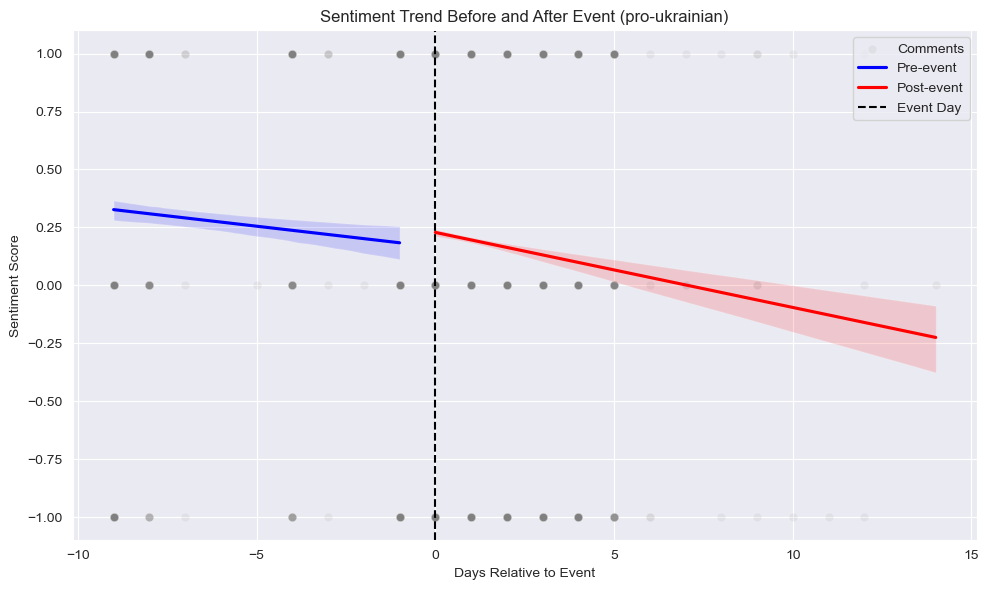

Saved figures/sentiment_trend_pro_ukrainian.png


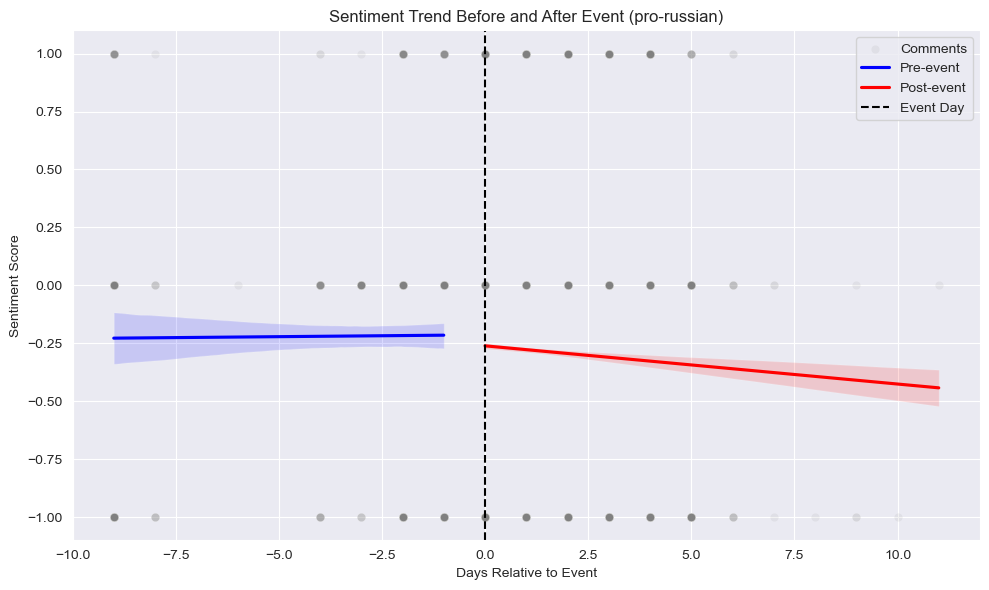

Saved figures/sentiment_trend_pro_russian.png


In [90]:
# Loopping over blocs
for bloc in ["pro-ukrainian", "pro-russian"]:
    df_bloc = df_comments[df_comments["bloc"] == bloc].copy()
    df_bloc = df_bloc.dropna(subset=["days_relative", "sentiment_numeric"])

    # Splitting pre/post event
    df_pre = df_bloc[df_bloc["days_relative"] < 0]
    df_post = df_bloc[df_bloc["days_relative"] >= 0]

    plt.figure(figsize=(10, 6))
    
    # Plotting data points
    sns.scatterplot(data=df_bloc, x="days_relative", y="sentiment_numeric", alpha=0.1, label="Comments", color="gray")

    # Plotting regression lines
    sns.regplot(data=df_pre, x="days_relative", y="sentiment_numeric", label="Pre-event", scatter=False, color="blue")
    sns.regplot(data=df_post, x="days_relative", y="sentiment_numeric", label="Post-event", scatter=False, color="red")

    # Visualizing
    plt.axvline(x=0, color="black", linestyle='--', label="Event Day")
    plt.title(f"Sentiment Trend Before and After Event ({bloc})")
    plt.xlabel("Days Relative to Event")
    plt.ylabel("Sentiment Score")
    plt.legend()
    plt.tight_layout()
    
    # Saving figure
    filename = f"figures/sentiment_trend_{bloc.replace('-', '_')}.png"
    plt.savefig(filename, dpi=600)
    plt.show()

    print(f"Saved {filename}")

# Sentiment change towards the leaders:

To capture ideological divergence in public responses, all comment-level analyses were conducted separately for pro-Ukrainian and pro-Russian channels. This partitioning enables a clearer interpretation of sentiment trends in each information environment, consistent with the known polarization of Telegram discourse. Splitting the data avoids masking differences in emotional tone and engagement that arise from fundamentally different narrative framings across the two groups. This also allows for a direct comparison between user reactions and the framing strategies identified in the qualitative channel-level analysis."

In [116]:
def analyze_sentiment_toward_figure(
    df, 
    figure_name, 
    keywords=None, 
    event_label="Event Day", 
    channel_group=None, 
    save_dir="figures",
    save_absolute=True,
    save_timeline=True,
    dpi=600,
    min_n_per_period=0,
    layout="stacked",
    # NEW:
    show_proportion=True,
    ci_alpha=0.05,
    smooth=True,
    lowess_frac=0.3,
    min_n_for_ci=20,
    plot_which=("positive","negative","neutral"),
    sentiment_col="model_sentiment",   # ← set to "rubert_sentiment_label" or "manual_label" if needed
    return_data=False
):
    """
    Extended: adds proportion plot with Wilson CIs + LOESS smoothing.
    Expects df columns: ['bloc','text_transformed','period', sentiment_col, 'days_relative'].
    """
    os.makedirs(save_dir, exist_ok=True)
    if keywords is None:
        keywords = [figure_name]

    # sanity
    if sentiment_col not in df.columns:
        raise KeyError(f"Sentiment column '{sentiment_col}' not found. Available: {list(df.columns)}")

    # Optional subset by bloc
    data = df if channel_group is None else df[df["bloc"] == channel_group]

    # Regex: case-insensitive, with safer boundaries for Cyrillic nicknames
    parts = []
    for k in keywords:
        k_esc = re.escape(k)
        if re.search(r'[A-Za-z]', k):   # Latin words → \b … \b
            parts.append(rf'\b{k_esc}\b')
        else:                           # Cyrillic/nicknames → looser token boundary
            parts.append(rf'(?<!\w){k_esc}(?!\w)')
    pattern = '|'.join(parts)

    df_fig = data[data["text_transformed"].str.contains(pattern, case=False, na=False, regex=True)].copy()
    audience = f" ({channel_group})" if channel_group else ""
    print(f"Comments mentioning {figure_name}{audience}: {len(df_fig)}")
    if df_fig.empty:
        print("No data; skipping.")
        return None if return_data else None

    # Normalize sentiment values to lowercase strings
    df_fig[sentiment_col] = df_fig[sentiment_col].astype(str).str.strip().str.lower()

    # ---------- PRE/POST BAR CHARTS (absolute + proportional) ----------
    dist = (df_fig.groupby(["period", sentiment_col]).size().unstack(fill_value=0))

    # Flatten MultiIndex if present
    if isinstance(dist.columns, pd.MultiIndex):
        dist.columns = dist.columns.get_level_values(-1)

    dist.columns = dist.columns.astype(str).str.strip().str.lower()
    expected_order = ["negative","neutral","positive"]
    dist = dist.reindex(columns=expected_order, fill_value=0)
    dist_norm = dist.div(dist.sum(axis=1), axis=0).fillna(0)

    # Layout for on-screen display
    if layout == "side":
        fig1, axs = plt.subplots(1, 2, figsize=(20, 7), constrained_layout=True)
        ax_abs, ax_prop = axs[0], axs[1]
    else:
        fig1, axs = plt.subplots(2, 1, figsize=(10, 12), constrained_layout=True)
        ax_abs, ax_prop = axs[0], axs[1]

    # Absolute
    dist.plot(kind="bar", ax=ax_abs, title=f"Absolute Sentiment: {figure_name}{audience}")
    ax_abs.set_ylabel("Comment Count"); ax_abs.set_xlabel("Period")
    ax_abs.legend(title="Sentiment"); ax_abs.grid(True, axis='y', alpha=.3)
    for i, total in enumerate(dist.sum(axis=1)):
        ax_abs.text(i - 0.18, total + max(5, total*0.02), f"n={int(total)}", fontsize=9)

    # Proportional
    dist_norm.plot(kind="bar", ax=ax_prop, title=f"Proportional Sentiment: {figure_name}{audience}")
    ax_prop.set_ylabel("Proportion of Comments"); ax_prop.set_xlabel("Period")
    ax_prop.legend(title="Sentiment"); ax_prop.grid(True, axis='y', alpha=.3)

    if min_n_per_period and any(dist.sum(axis=1) < min_n_per_period):
        fig1.suptitle(
            f"⚠ Some periods have <{min_n_per_period} mentions — interpret proportions cautiously.",
            fontsize=10, y=1.02
        )
    plt.show()

    # Save absolute bars
    safe_name = re.sub(r'[^A-Za-z0-9_\-]+', '_', f"{figure_name}_{channel_group or 'all'}")
    if save_absolute:
        out_abs = os.path.join(save_dir, f"abs_sentiment_{safe_name}.png")
        fig_abs, ax_abs2 = plt.subplots(figsize=(8, 6), constrained_layout=True)
        dist.plot(kind="bar", ax=ax_abs2)
        ax_abs2.set_title(f"Absolute Sentiment: {figure_name}{audience}")
        ax_abs2.set_ylabel("Comment Count"); ax_abs2.set_xlabel("Period")
        ax_abs2.legend(title="Sentiment"); ax_abs2.grid(True, axis='y', alpha=.3)
        for i, total in enumerate(dist.sum(axis=1)):
            ax_abs2.text(i - 0.18, total + max(5, total*0.02), f"n={int(total)}", fontsize=9)
        fig_abs.savefig(out_abs, dpi=dpi); plt.close(fig_abs)
        print(f"Saved absolute bars → {out_abs}")

    # ---------- TIME SERIES (counts + proportion + CI + smoothing) ----------
    df_fig["days_relative"] = df_fig["days_relative"].astype(int)

    timeline = (df_fig.groupby(["days_relative", sentiment_col]).size().unstack(fill_value=0))
    if isinstance(timeline.columns, pd.MultiIndex):
        timeline.columns = timeline.columns.get_level_values(-1)
    timeline.columns = timeline.columns.astype(str).str.strip().str.lower()
    timeline = timeline.reindex(columns=expected_order, fill_value=0)
    timeline["n"] = timeline.sum(axis=1)

    # counts over time
    fig_tl, ax_tl = plt.subplots(figsize=(12, 6), constrained_layout=True)
    plot_cols = [c for c in list(plot_which) if c in timeline.columns]  # robust selection
    timeline[plot_cols].plot(linestyle='-', marker='o', ax=ax_tl)
    ax_tl.axvline(x=0, color='black', linestyle='--', label=event_label)
    ax_tl.set_title(f"Sentiment Over Time Toward {figure_name}{audience}")
    ax_tl.set_xlabel("Days Relative to Event"); ax_tl.set_ylabel("Number of Comments")
    ax_tl.grid(True, axis='y', alpha=.3)
    ax_tl.legend(title="Sentiment")
    plt.show()

    if save_timeline:
        out_tl = os.path.join(save_dir, f"timeline_{safe_name}.png")
        fig_tl.savefig(out_tl, dpi=dpi); plt.close(fig_tl)
        print(f"Saved timeline → {out_tl}")

    # positive share with CI + LOESS
    prop_output_path = None
    if show_proportion:
        ts = timeline.reset_index().rename(columns={"index":"days_relative"})
        ts = ts[ts["n"] > 0].copy()
        ts["x"] = ts["positive"].astype(int)
        ts["n"] = ts["n"].astype(int)
        ts["prop_pos"] = ts["x"] / ts["n"]

        ci_bounds = ts.apply(
            lambda r: smp.proportion_confint(count=r["x"], nobs=r["n"], alpha=ci_alpha, method="wilson"),
            axis=1
        )
        ts["ci_low"] = ci_bounds.apply(lambda t: t[0])
        ts["ci_high"] = ci_bounds.apply(lambda t: t[1])
        ts.loc[ts["n"] < min_n_for_ci, ["ci_low","ci_high"]] = np.nan

        if smooth and len(ts) >= 5:
            lowess = sm.nonparametric.lowess
            smoothed = lowess(ts["prop_pos"], ts["days_relative"], frac=lowess_frac, return_sorted=True)
            ts["prop_pos_smooth"] = np.interp(ts["days_relative"], smoothed[:,0], smoothed[:,1])
        else:
            ts["prop_pos_smooth"] = ts["prop_pos"]

        fig_p, ax_p = plt.subplots(figsize=(12, 6), constrained_layout=True)
        ax_p.plot(ts["days_relative"], ts["prop_pos"], alpha=0.35, marker='o', linestyle='-',
                  label="Daily proportion (positive)")
        ax_p.plot(ts["days_relative"], ts["prop_pos_smooth"], linewidth=2.0, label="LOESS smooth (positive)")
        ax_p.fill_between(ts["days_relative"], ts["ci_low"], ts["ci_high"], alpha=0.2, label="95% CI (Wilson)")
        ax_p.axvline(x=0, color="black", linestyle='--', label=event_label)
        ax_p.set_title(f"Positive Sentiment Share Toward {figure_name}{audience}")
        ax_p.set_xlabel("Days Relative to Event"); ax_p.set_ylabel("Share of Comments")
        ax_p.set_ylim(0, 1); ax_p.grid(True, axis="y", alpha=.3); ax_p.legend()
        plt.show()

        prop_output_path = os.path.join(save_dir, f"timeline_prop_pos_{safe_name}.png")
        fig_p.savefig(prop_output_path, dpi=dpi); plt.close(fig_p)
        print(f"Saved proportion timeline (+CI/LOESS) → {prop_output_path}")

    if return_data:
        return {"df_fig": df_fig, "dist": dist, "timeline": timeline, "prop_ts": ts if show_proportion else None,
                "paths": {"abs": out_abs if save_absolute else None,
                          "timeline": out_tl if save_timeline else None,
                          "prop": prop_output_path}}

Comments mentioning Zelensky (pro-ukrainian): 1409


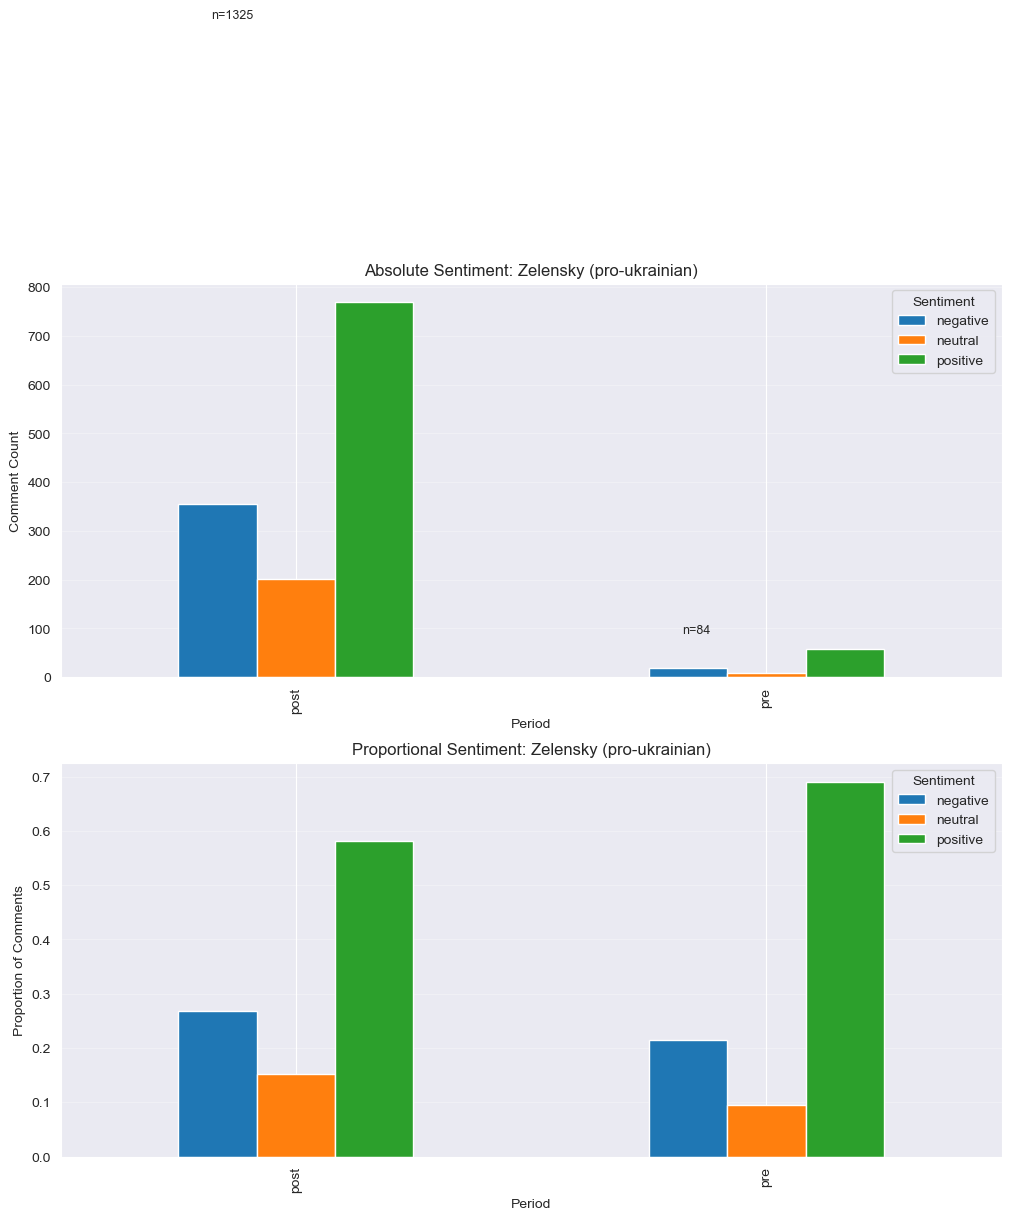

Saved absolute bars → figures/abs_sentiment_Zelensky_pro-ukrainian.png


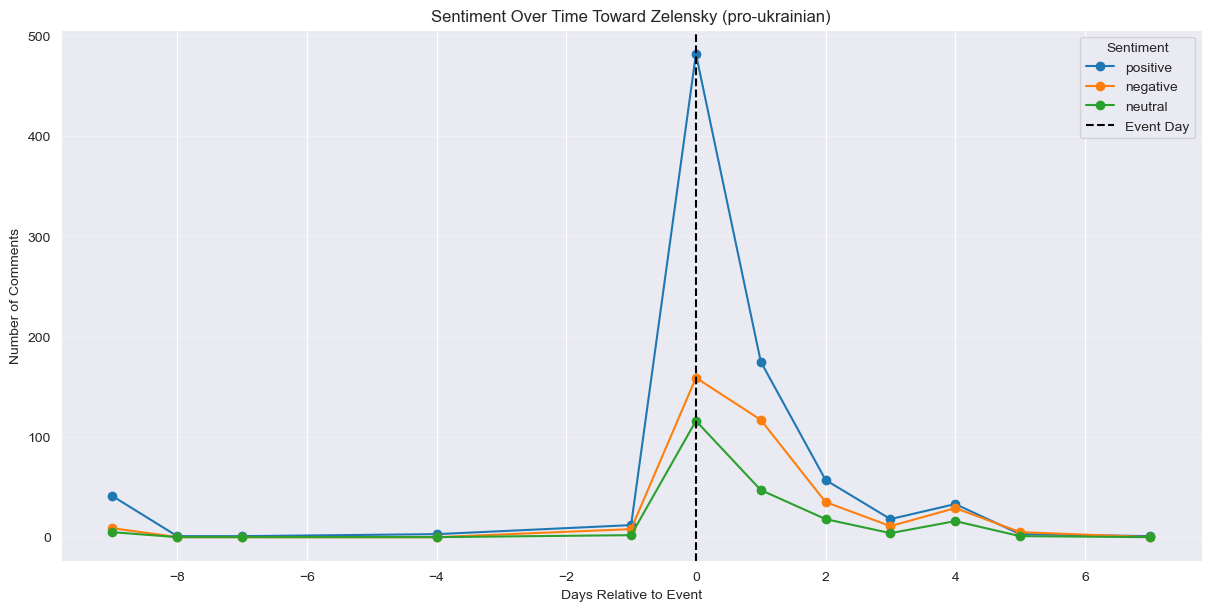

Saved timeline → figures/timeline_Zelensky_pro-ukrainian.png


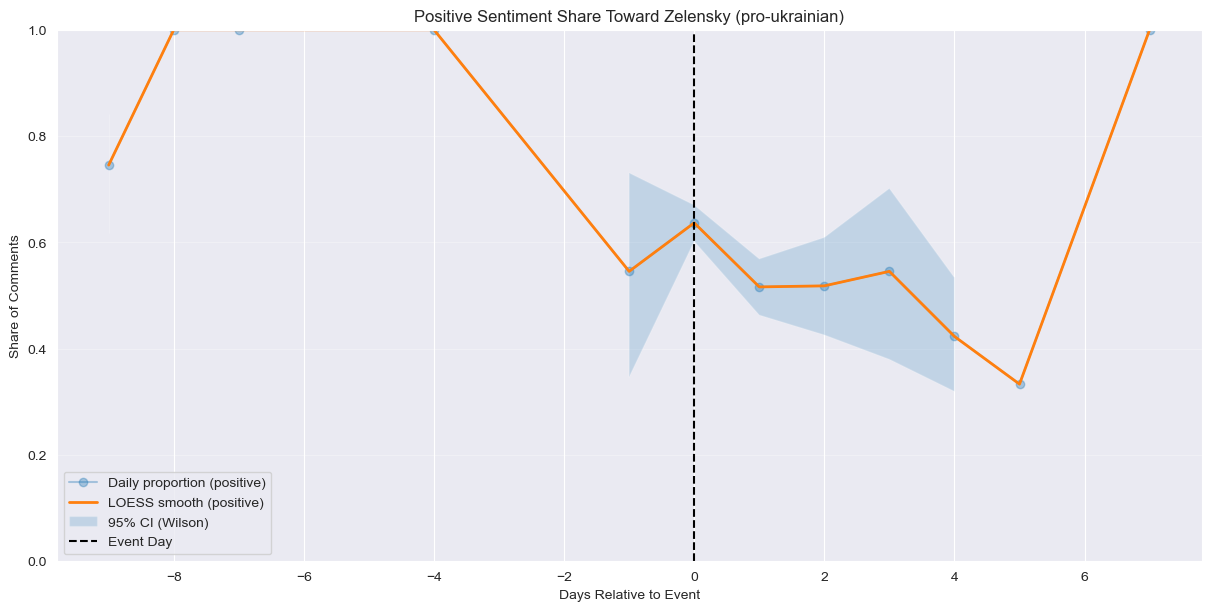

Saved proportion timeline (+CI/LOESS) → figures/timeline_prop_pos_Zelensky_pro-ukrainian.png
Comments mentioning Zelensky (pro-russian): 1681


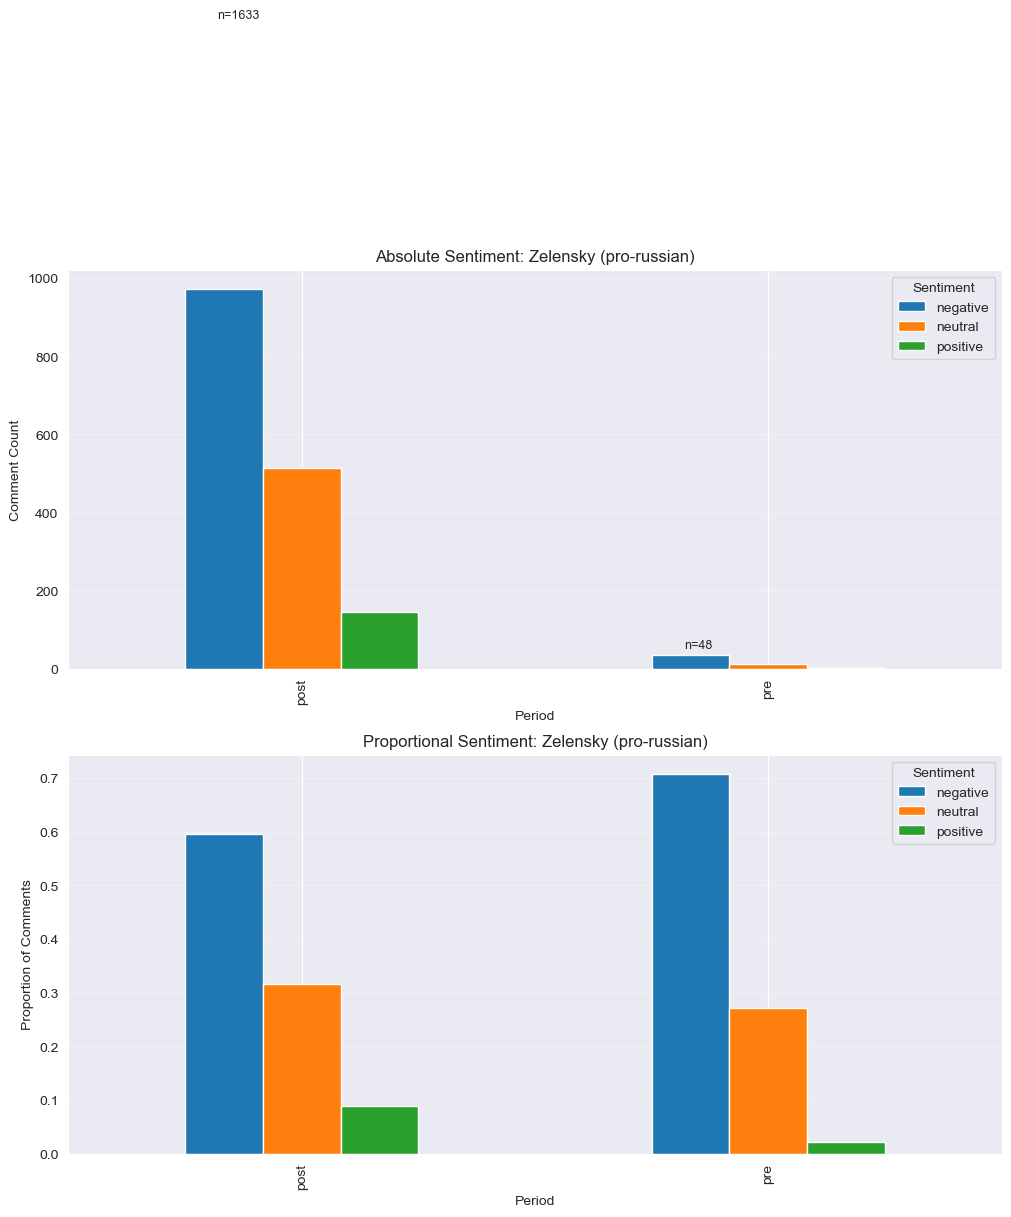

Saved absolute bars → figures/abs_sentiment_Zelensky_pro-russian.png


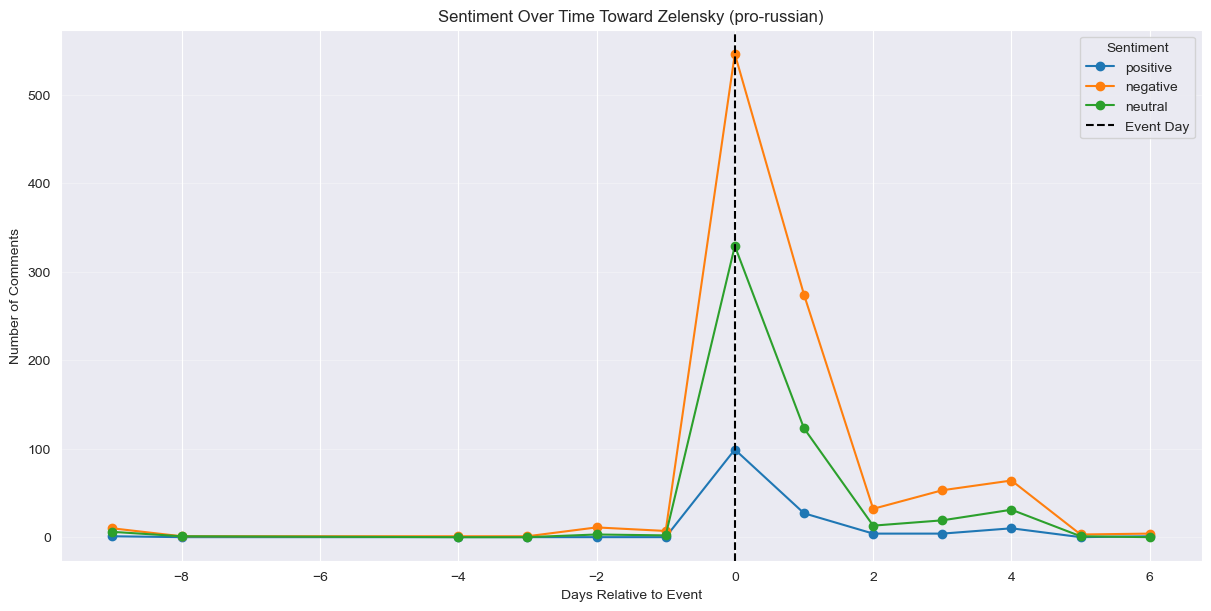

Saved timeline → figures/timeline_Zelensky_pro-russian.png


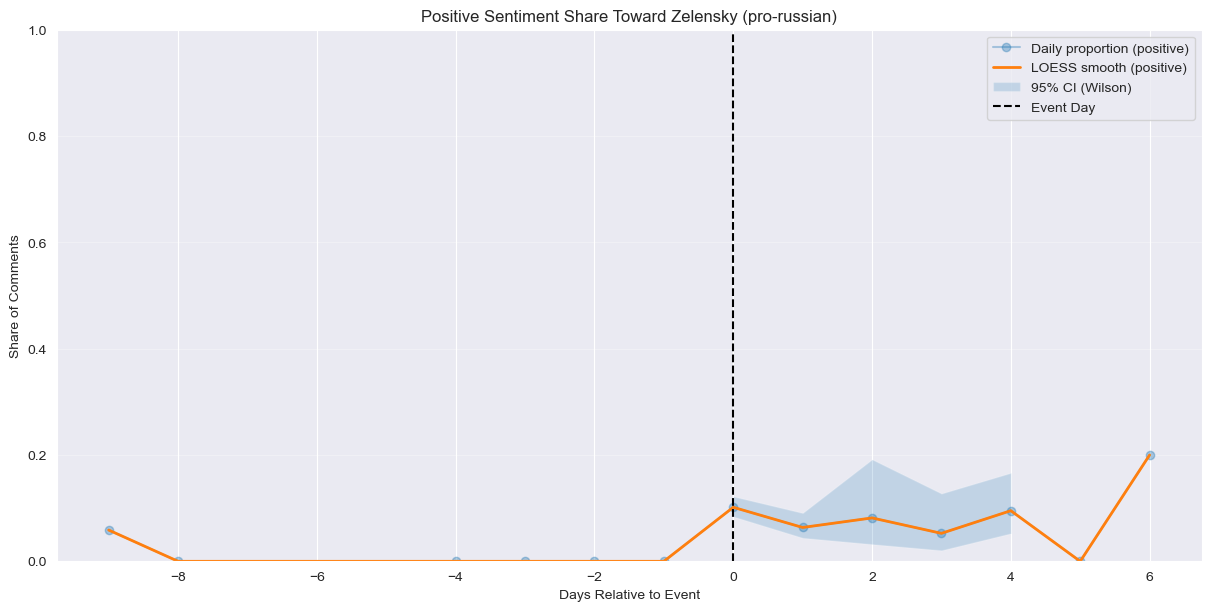

Saved proportion timeline (+CI/LOESS) → figures/timeline_prop_pos_Zelensky_pro-russian.png


In [117]:
# --- Zelensky — pro-Ukrainian audience ---
analyze_sentiment_toward_figure(
    df_comments,
    figure_name="Zelensky",
    keywords=["Zelensky","зеленський","зеленский","зе","зеля","зеле","зеленським","зеленскому","зеленському","зеленського"],
    channel_group="pro-ukrainian",
    save_dir="figures",
    save_absolute=True,
    save_timeline=True,
    dpi=600,
    min_n_per_period=25  # optional guardrail for proportional interpretation
)

# --- Zelensky — pro-Russian audience ---
analyze_sentiment_toward_figure(
    df_comments,
    figure_name="Zelensky",
    keywords=["Zelensky","зеленський","зеленский","зе","зеля","зеле", "зелей", "зеленском","зеленскому", "зеленским"],
    channel_group="pro-russian",
    save_dir="figures",
    save_absolute=True,
    save_timeline=True,
    dpi=600,
    min_n_per_period=25
)

Comments mentioning Trump (pro-ukrainian): 2030


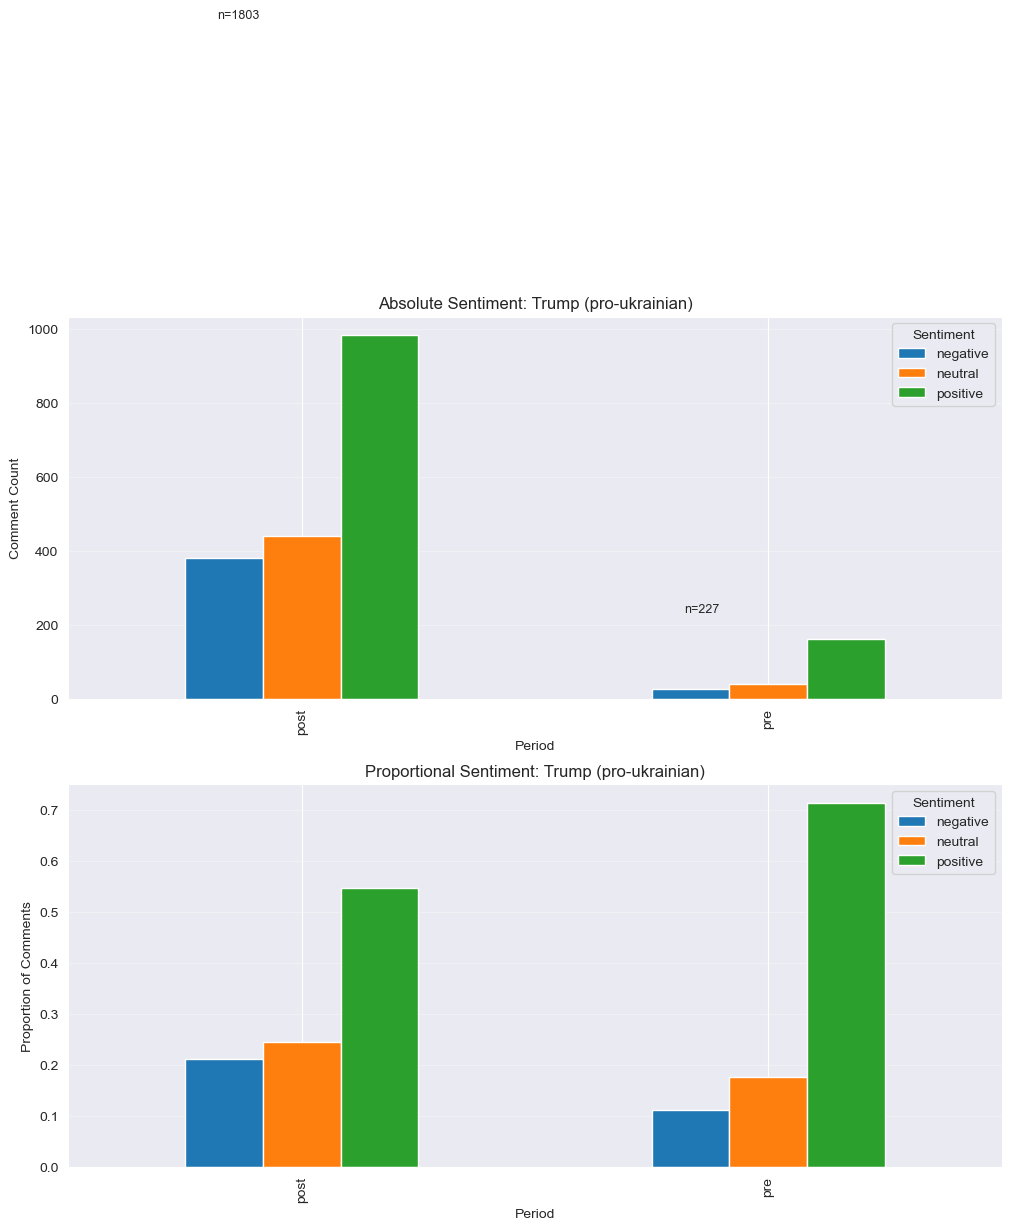

Saved absolute bars → figures/abs_sentiment_Trump_pro-ukrainian.png


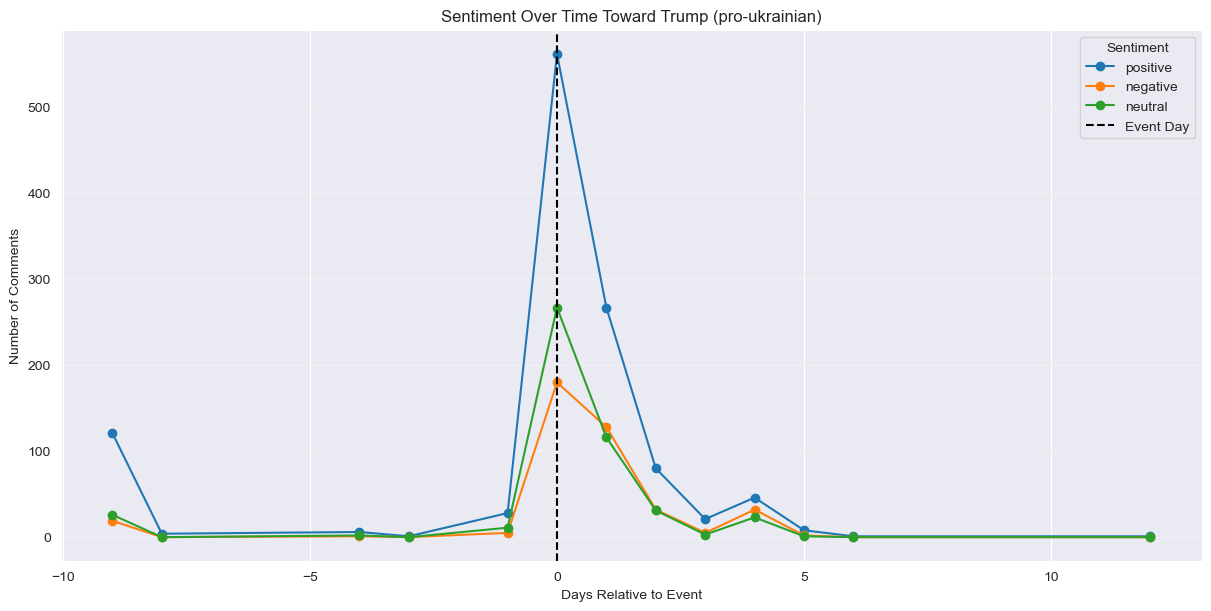

Saved timeline → figures/timeline_Trump_pro-ukrainian.png


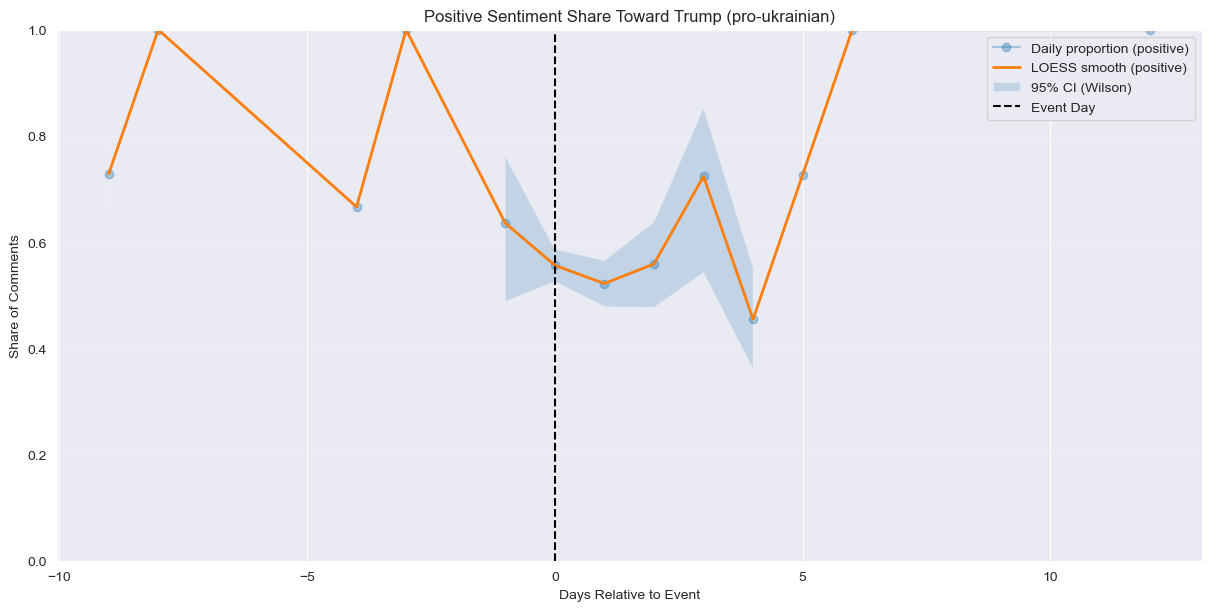

Saved proportion timeline (+CI/LOESS) → figures/timeline_prop_pos_Trump_pro-ukrainian.png
Comments mentioning Trump (pro-russian): 1575


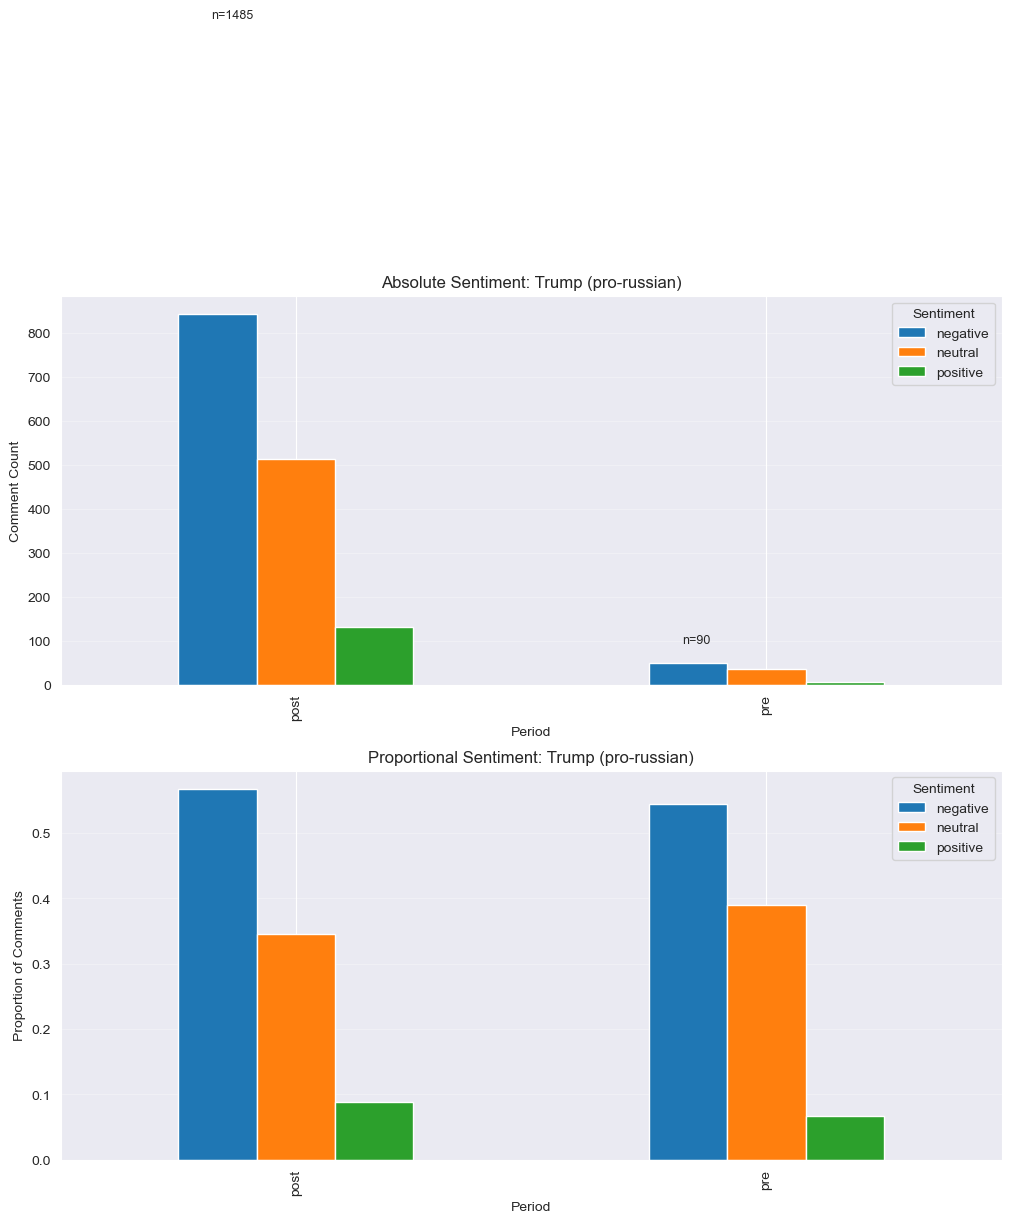

Saved absolute bars → figures/abs_sentiment_Trump_pro-russian.png


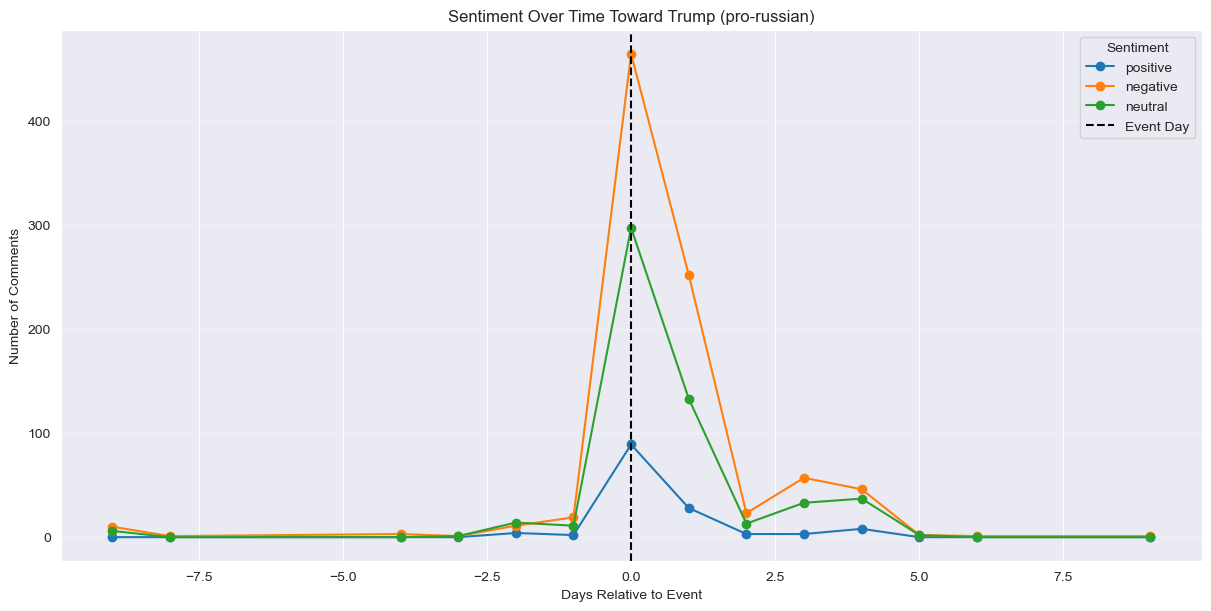

Saved timeline → figures/timeline_Trump_pro-russian.png


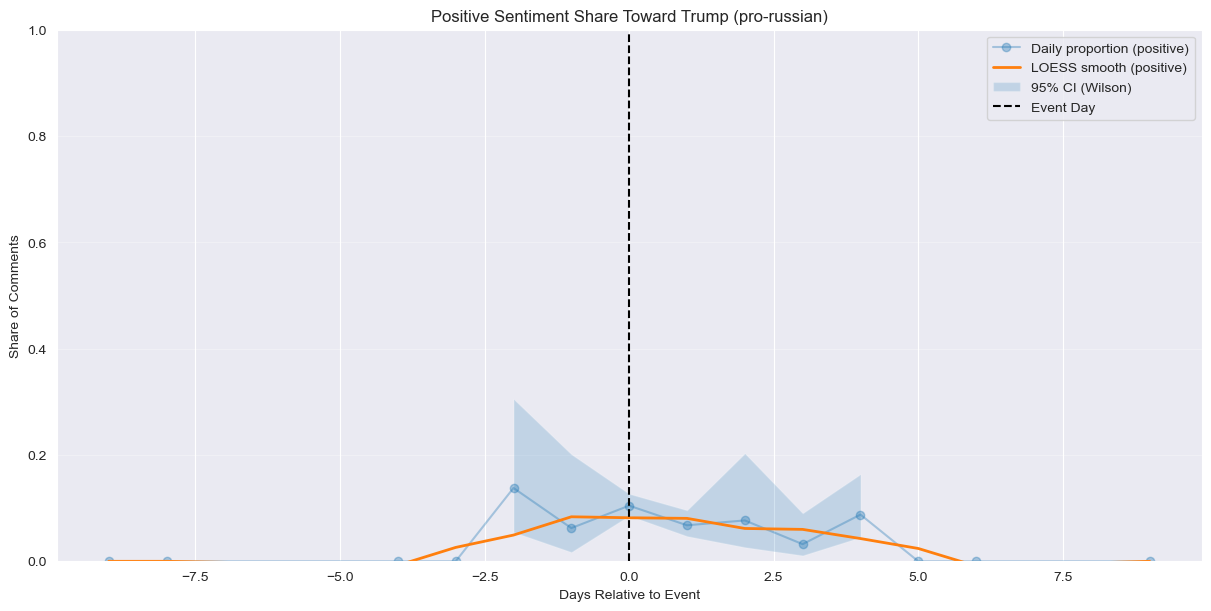

Saved proportion timeline (+CI/LOESS) → figures/timeline_prop_pos_Trump_pro-russian.png


In [118]:
# --- Trump — pro-Ukrainian audience ---
analyze_sentiment_toward_figure(
    df_comments,
    figure_name="Trump",
    keywords=["Trump", "трамп", "трампа", "трампу", "трампом"],
    channel_group="pro-ukrainian",
    save_dir="figures",
    save_absolute=True,
    save_timeline=True,
    dpi=600,
    min_n_per_period=25  # optional guardrail for proportional interpretation
)

# --- Trump — pro-Russian audience --- 
analyze_sentiment_toward_figure(
    df_comments,
    figure_name="Trump",
    keywords=["Trump", "трамп", "трампа", "трампу", "трампом"],
    channel_group="pro-russian",
    save_dir="figures",
    save_absolute=True,
    save_timeline=True,
    dpi=600,
    min_n_per_period=25
)

Comments mentioning Putin (pro-ukrainian): 372


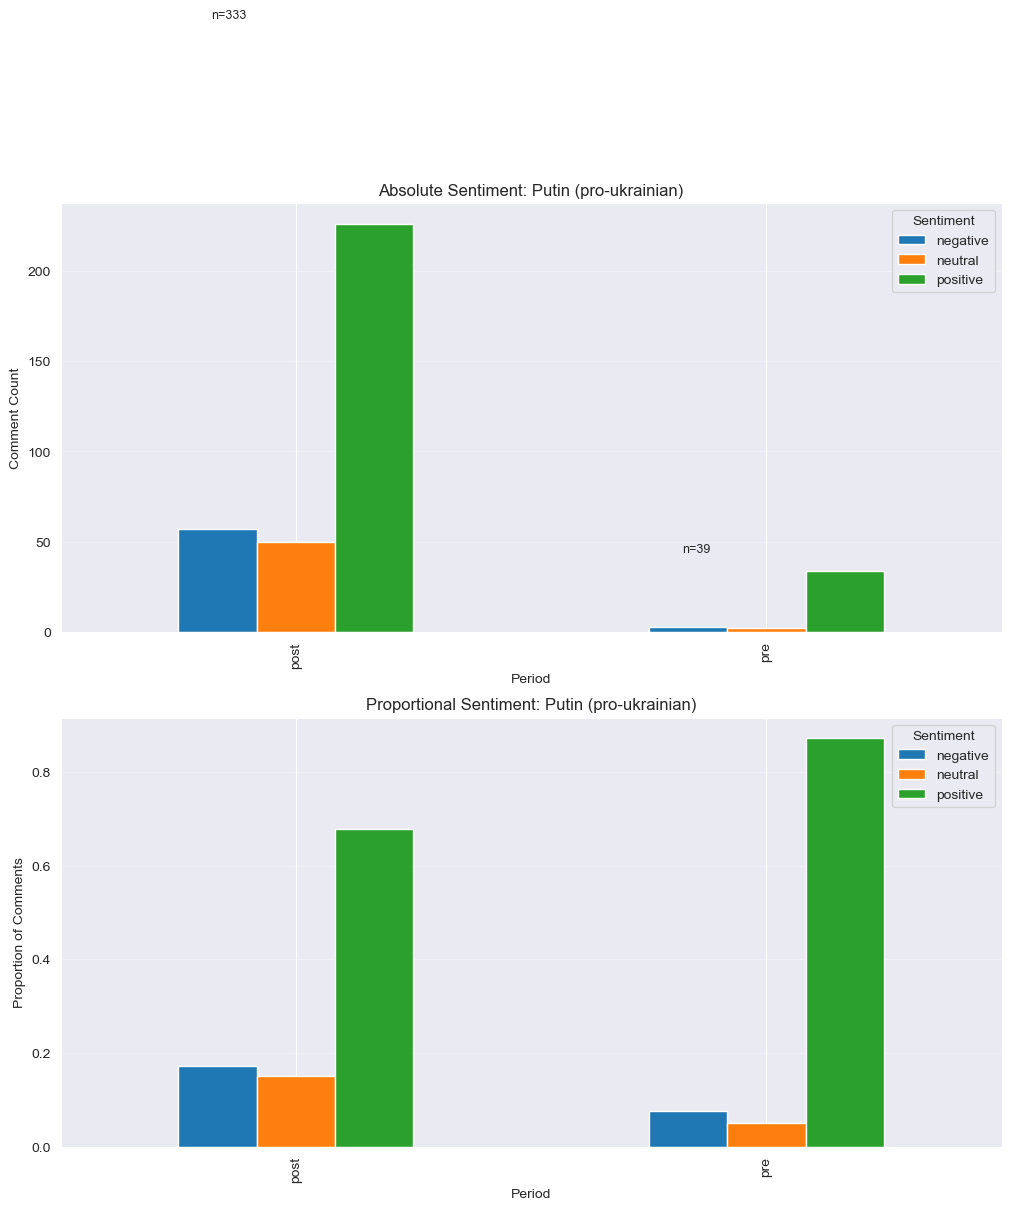

Saved absolute bars → figures/abs_sentiment_Putin_pro-ukrainian.png


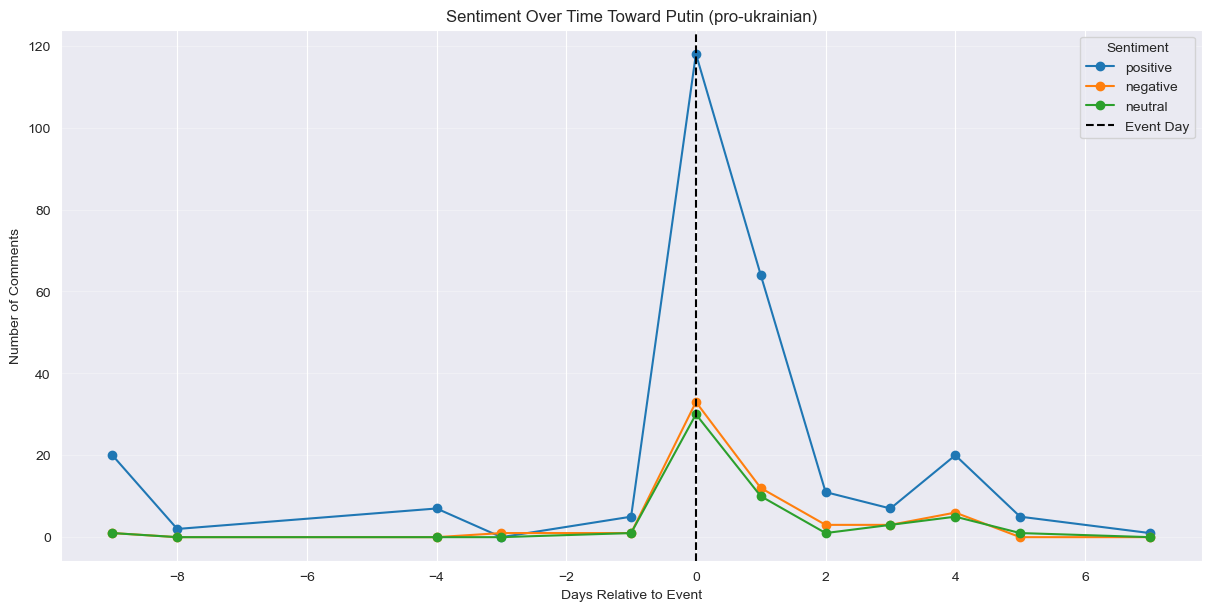

Saved timeline → figures/timeline_Putin_pro-ukrainian.png


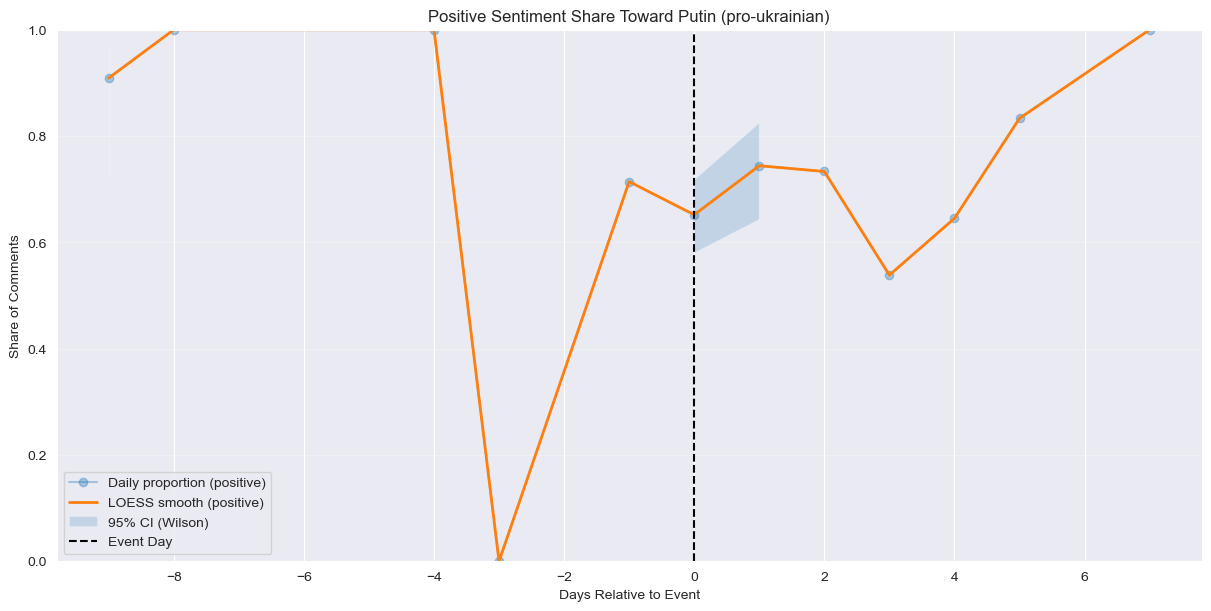

Saved proportion timeline (+CI/LOESS) → figures/timeline_prop_pos_Putin_pro-ukrainian.png
Comments mentioning Putin (pro-russian): 227


/Applications/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


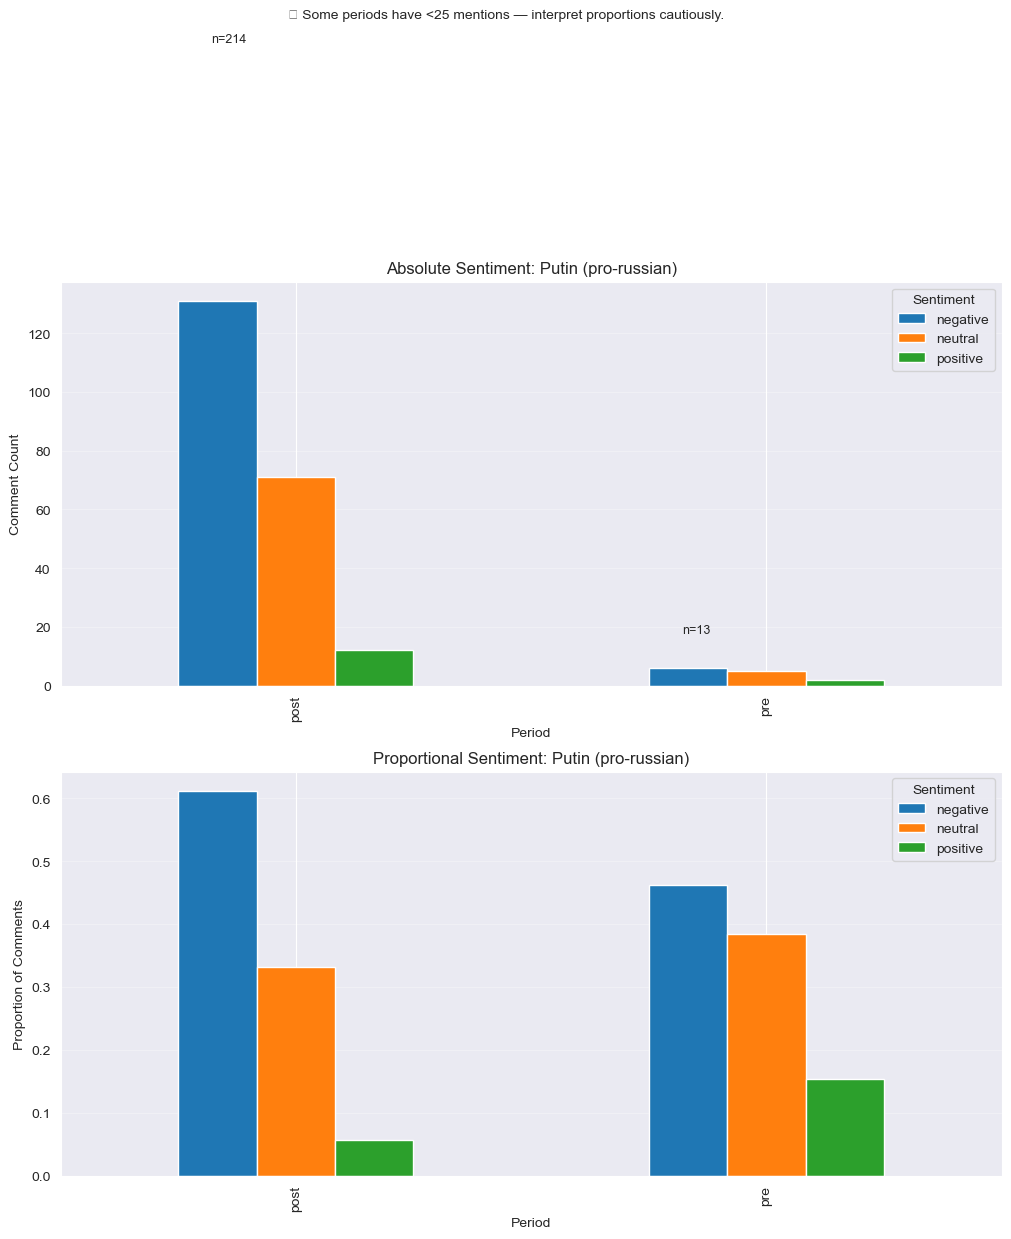

Saved absolute bars → figures/abs_sentiment_Putin_pro-russian.png


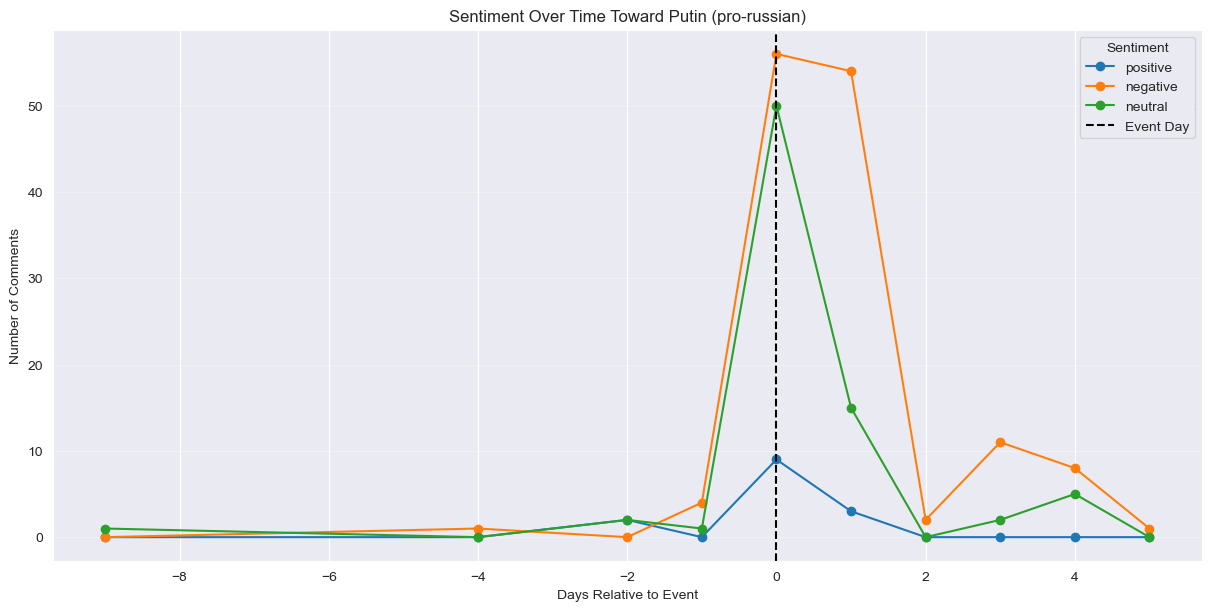

Saved timeline → figures/timeline_Putin_pro-russian.png


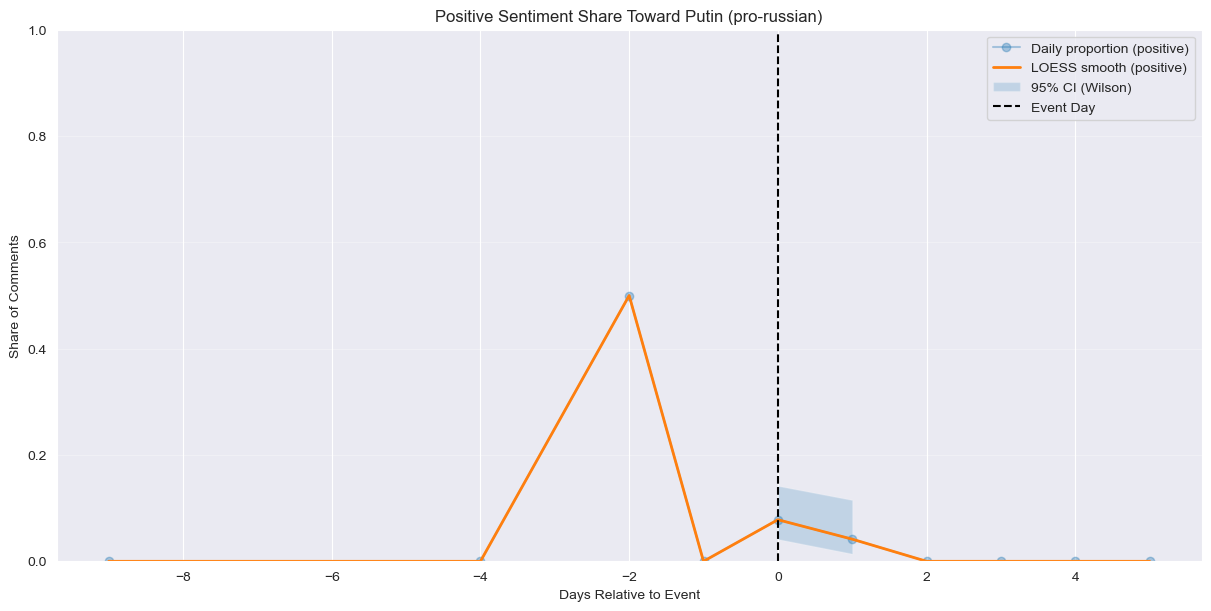

Saved proportion timeline (+CI/LOESS) → figures/timeline_prop_pos_Putin_pro-russian.png


In [119]:
# --- Putin — pro-Ukrainian audience ---
analyze_sentiment_toward_figure(
    df_comments,
    figure_name="Putin",
    keywords=["Putin", "путін", "путіна", "путіну", "Putin", "путлер", "путлера", "путлеру", "путлером", "путлєр", "путлєра", "путлєру"],
    channel_group="pro-ukrainian",
    save_dir="figures",
    save_absolute=True,
    save_timeline=True,
    dpi=600,
    min_n_per_period=25  
)

# --- Putin — pro-Russian audience ---
analyze_sentiment_toward_figure(
    df_comments,
    figure_name="Putin",
    keywords=["Putin", "путин", "путина", "путину", "путлер", "путлера", "путлеру", "путлером"],
    channel_group="pro-russian",
    save_dir="figures",
    save_absolute=True,
    save_timeline=True,
    dpi=600,
    min_n_per_period=25
)

The following helper functions were added to complement the main `analyze_sentiment_toward_figure` routine. They address two key limitations identified during interpretation of the time-series plots:

1. **Random sample inspection (`sample_comments`)**  
   This function draws a random subset of comments labeled with a specific sentiment (e.g., "positive" toward Trump).  
   By manually reading these examples, it is possible to detect systematic misclassification by the sentiment model, especially in cases of sarcasm or ironic praise that the model may interpret as genuinely positive. This step provides a qualitative validity check on the automated results.
   1. 
2. **Pre-/Post-event aggregation (`aggregate_pre_post`)**  
   The daily time-series visualizations can be noisy because of highly uneven comment volumes (very large spikes on the event day, very small counts afterwards). To reduce this volatility, this function collapses all comments into two bins—before the event and after the event—and calculates both absolute counts and proportional distributions of sentiments.  
   This yields a clearer picture of overall before/after changes, reducing the influence of small-N fluctuations.

Together, these additions make the analysis more robust. The time-series plots remain useful for showing the dynamics of attention and engagement, but the aggregated distributions and random sample checks help verify whether the sentiment shifts are genuine or artefacts of the model and data.

In [120]:
def sample_comments(df, figure_name, sentiment="positive", n=20):
    """
    Show a random sample of comments classified as a given sentiment
    for manual inspection (e.g., sarcasm).
    """
    subset = df[
        (df["model_sentiment"] == sentiment) &
        (df["text_transformed"].str.contains(figure_name, case=False, na=False))
    ]
    return subset.sample(min(n, len(subset)), random_state=42)[["text_transformed", "model_sentiment"]]

In [121]:
sample_comments(df_comments, "Trump", sentiment="positive", n=15)

,text_transformed,model_sentiment
9631,дивився всю ніч різні американські підкасти/но...,positive
19154,пойду куплю trump на криптобирже - надо задона...,positive
300,**фредерік крайст трамп-старший** ([англ.]( __...,positive
18162,"""trump and vence punish ukrainian bitch on pub...",positive
